In [3]:
import pandas as pd
import os
from fuc import pyvcf
from tqdm.notebook import tqdm
import pybedtools
import numpy as np
import networkx
import datetime
import warnings

tqdm.pandas()

<h1> Read the data </h1>

In [77]:
basedir = "/home/vfishman/projects/regina_deafness/"

samples = [f for f in os.listdir(basedir) if os.path.isdir(f) and f.find("Gen")!=-1]
samples

['19412RT-Gen005-PCRfree-30X',
 '19412E-Gen001-PCRfree',
 '19412JR-Gen005-PCRfree-30X',
 '20487A-Gen001-PCRfree',
 '20487-Gen001-PCRfree',
 '20487J-Gen001-PCRfree',
 '20487N-Gen001-PCRfree',
 '19412AL-Gen005-PCRfree-30X']

In [78]:
SVs = []

# read all vcf files

sv_caller_files = {"cue":"/reports/svs.vcf",
                  "delly_sv":"/delly/delly.sv.vcf"
                  }

SVs = {}

for sample in tqdm(samples):
    for sv_caller,sv_caller_file in sv_caller_files.items():
        fname = os.path.join(basedir,sample) + sv_caller_file
        vcfFrame = pyvcf.VcfFrame.from_file(fname)
        vcfFrame.name = sample+":"+sv_caller
        SVs[vcfFrame.name] = vcfFrame

# convert to bed_file with name correspoding to SV id

# merge overlapping intervals keeping track of ids

# construct any query

  0%|          | 0/8 [00:00<?, ?it/s]

In [79]:
basedir2 = "/home/vfishman/projects/debora_twins/"

samples2 = [f for f in os.listdir(basedir2) if os.path.isdir(basedir2+f) and \
            f.startswith("20")]
print (samples2)

for sample in tqdm(samples2):
    for sv_caller,sv_caller_file in sv_caller_files.items():
        fname = os.path.join(basedir2,sample) + sv_caller_file
        vcfFrame = pyvcf.VcfFrame.from_file(fname)
        vcfFrame.name = sample+":"+sv_caller
        SVs[vcfFrame.name] = vcfFrame

['2030005417_GRV_8GjHK9a', '20210442-027']


  0%|          | 0/2 [00:00<?, ?it/s]

In [80]:
next(SVs.values().__iter__()).name

'19412RT-Gen005-PCRfree-30X:cue'

In [206]:
def vcfFrame2bed(vf, extend = 0):   
    chrm = vf.df["CHROM"]
    start = (vf.df["POS"] - extend).apply(lambda x: max(x,0))
    try:
        end = (vf.df.apply(pyvcf.row_parseinfo, args=('END',), axis=1).astype(int) + extend)
    except:
        print (vf.name, vf.caller)
        raise
    svtype = vf.df.apply(pyvcf.row_parseinfo, args=('SVTYPE',), axis=1).astype(str) 
    svtype = svtype.apply(lambda x: x.replace("IDUP","DUP"))
    breakpoints_df = pd.DataFrame({"chrm":chrm,
                         "start":start,
                         "end":end,
                         "SV_type":svtype,
                         "FILTER":vf.df["FILTER"].values}
                       )
    breakpoints_df["original_index"] = breakpoints_df.index.values

    # represent inversions as two breakpoints, one for each inversion side
    breakpoints_inv = breakpoints_df.query("SV_type=='INV'")
    n_iversions = len(breakpoints_inv)
    n_total = len(breakpoints_df)
    
    breakpoints_inv_start = pd.DataFrame(breakpoints_inv, copy=True)
    
    breakpoints_inv_end = pd.DataFrame(breakpoints_inv, copy=True)

    breakpoints_inv_start.loc[:,"end"] = breakpoints_inv_start["start"]+2*extend + 1
    breakpoints_inv_end.loc[:,"start"] = (breakpoints_inv_end["end"]-2*extend-1).apply(lambda x: max(x,0))
    breakpoints_inv = pd.concat([breakpoints_inv_start,breakpoints_inv_end]).reset_index(drop=True)
    
    breakpoints_df = pd.concat([breakpoints_df.query("SV_type!='INV'"),
                                breakpoints_inv]
                              ).reset_index(drop=True)

    assert breakpoints_df["original_index"].duplicated().sum() == len(breakpoints_inv_start)

    # print (len(breakpoints_df) , n_total , n_iversions, len(breakpoints_inv), len(breakpoints_inv_start),len(breakpoints_inv_end))
    assert len(breakpoints_df) == n_total + n_iversions
    name = (pd.Series(breakpoints_df.index.values).astype(str) + ":" + \
            pd.Series(breakpoints_df.original_index.values).astype(str) + \
            ":"+vf.name).values
    breakpoints_df["name"] = name

    return breakpoints_df

In [207]:
SVs_bed = list(map(vcfFrame2bed,tqdm(SVs.values())))

  0%|          | 0/20 [00:00<?, ?it/s]

In [208]:
SVs_bed_combined = pd.concat(SVs_bed)

In [209]:
SVs_bed_combined

chrm      start        end SV_type   FILTER  \
0                           chr14   40140613   40148469     DEL     PASS   
1                           chr14   79639949   79648707     DEL     PASS   
2                           chr14   35136247   35145840     DEL     PASS   
3                           chr14   18539053   18547319     DEL     PASS   
4                           chr14  105906883  105916674     DEL     PASS   
...                           ...        ...        ...     ...      ...   
30103      chrUn_KN707896v1_decoy      32067      32068     INV  LowQual   
30104      chrUn_KN707896v1_decoy      30800      30801     INV  LowQual   
30105  chrUn_JTFH01000869v1_decoy        745        746     INV     PASS   
30106  chrUn_JTFH01001807v1_decoy       3088       3089     INV  LowQual   
30107  chrUn_JTFH01001888v1_decoy       2643       2644     INV  LowQual   

       original_index                                name  
0                   0  0:0:19412RT-Gen005-PCRfree-30X:cue  
1                   1  1:1:19412RT-Gen005-PCRfree-30X:cue  
2                   2  2:2:19412RT-Gen005-PCRfree-30X:cue  
3                   3  3:3:19412RT-Gen005-PCRfree-30X:cue  
4                   5  4:5:19412RT-Gen005-PCRfree-30X:cue  
...               ...                                 ...  
30103           25581   30103:25581:20210442-027:delly_sv  
30104           25582   30104:25582:20210442-027:delly_sv  
30105           26761   30105:26761:20210442-027:delly_sv  
30106           27863   30106:27863:20210442-027:delly_sv  
30107           28047   30107:28047:20210442-027:delly_sv  

[666073 rows x 7 columns]

In [210]:
SVs_bed_combined.SV_type.value_counts()

DEL    242478
INV    221354
BND    140546
DUP     52161
INS      9534
Name: SV_type, dtype: int64

In [211]:
SVs_bed_combined["FILTER"].value_counts()

LowQual    485222
PASS       180851
Name: FILTER, dtype: int64

In [212]:
SVs_bed_combined["length"] = SVs_bed_combined["end"] - SVs_bed_combined["start"]

In [213]:
agg = SVs_bed_combined.groupby("SV_type")["length"].agg(["min","max","mean","std"])
assert np.all([i in ['BND', 'DEL', 'DUP', 'INS', 'INV'] for i in agg.index])
BND_types = ["BND","INS","INV"]
assert agg.loc[BND_types,"max"].max()<10
agg

min        max          mean           std
SV_type                                            
BND        1          1  1.000000e+00  0.000000e+00
DEL       16  242323058  1.641823e+06  1.365475e+07
DUP       60  242323169  5.043353e+06  2.250763e+07
INS        1          3  1.003881e+00  6.384348e-02
INV        1          1  1.000000e+00  0.000000e+00

<h1> Aggregate and overlap the data </h1>

In [214]:
def get_merged_intervals_BND(SVs_bed_combined_singe_type, merge_dist = 500):
    btool = pybedtools.BedTool.from_dataframe(
        SVs_bed_combined_singe_type[["chrm","start","end","name","SV_type"]])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        merged = btool.sort().merge(c=4,o="collapse",d=merge_dist).to_dataframe()
    ids = pd.Series(merged.index.values).astype(str).values
    svtype = ":" + SVs_bed_combined_singe_type.name
    merged_intevalIndex = ids + svtype
    merged["interval_index"] = merged_intevalIndex 
    return merged

def get_merged_intervals_CNV(SVs_bed_combined_singe_type, min_merge_overlap = 0.7):
    colnames = ["chrm","start","end","name","SV_type"]
    btool = pybedtools.BedTool.from_dataframe(
            SVs_bed_combined_singe_type[colnames])
    print (datetime.datetime.now(), "Sorting data")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sorted_bt = btool.sort()

    print (datetime.datetime.now(), "Computing intersection")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        intersect = sorted_bt.intersect(sorted_bt, 
                                     f=min_merge_overlap,
                                     r=True, sorted=True,
                                     wa=True, wb=True)\
                       .to_dataframe()
    print (datetime.datetime.now(), "Converting to graph")

    # note wierd names of columns 'name', 'itemRgb'
    # these are default bedtools names
    g = networkx.from_pandas_edgelist(intersect, source='name', target='itemRgb')
    # networkx.draw(g)
    assert not g.is_directed()
   
    print (datetime.datetime.now(), "Getting clusters")
    clusters = networkx.connected_components(g)
    sorted_as_df = sorted_bt.to_dataframe()
    sorted_as_df.columns = colnames

    print (datetime.datetime.now(), "Setting clusters info")
    sorted_as_df["interval_index"] = pd.NA
    assert not np.any(sorted_as_df["name"].duplicated())
    sorted_as_df = sorted_as_df.set_index("name")
    for cluster_id,cluster in tqdm(enumerate(clusters)):
        sorted_as_df.loc[list(cluster),"interval_index"] = str(cluster_id)
    sorted_as_df.loc[:,"interval_index"] = sorted_as_df.apply(
                                                lambda x: x["interval_index"]+":"+x["SV_type"],
                                                axis="columns"
                                            )
    print (datetime.datetime.now(), "Aggregating clusters")
    return sorted_as_df.reset_index(drop=False).groupby("interval_index").agg({
                                    "name": lambda x: ",".join(x),
                                    "start": min,
                                    "end": max,
                                    "SV_type":lambda x: list(x)[0],
                                    "chrm":lambda x: list(x)[0]
                                    }
                                ).reset_index(drop=False).rename(columns={"chrm":"chrom"})



In [215]:
SVs_bed_combined_merged_intervals_CNV = \
    SVs_bed_combined.query("SV_type in ['DEL','DUP']").\
                     groupby("SV_type").\
                     progress_apply(get_merged_intervals_CNV)

  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-10 16:14:54.385278 Sorting data
2023-07-10 16:14:55.281666 Computing intersection
2023-07-10 16:15:40.696945 Converting to graph
2023-07-10 16:16:02.626820 Getting clusters
2023-07-10 16:16:02.969895 Setting clusters info


0it [00:00, ?it/s]

2023-07-10 16:17:31.948572 Aggregating clusters
2023-07-10 16:17:49.733146 Sorting data
2023-07-10 16:17:50.015998 Computing intersection
2023-07-10 16:18:21.763189 Converting to graph
2023-07-10 16:18:35.487297 Getting clusters
2023-07-10 16:18:35.555468 Setting clusters info


0it [00:00, ?it/s]

2023-07-10 16:18:41.778960 Aggregating clusters


In [216]:
SVs_bed_combined_merged_intervals_CNV.reset_index(drop=True, inplace=True)
SVs_bed_combined_merged_intervals_CNV

interval_index                                               name  \
0               0:DEL  0:0:19412E-Gen001-PCRfree:delly_sv,0:0:19412RT...   
1          100000:DEL    21130:23139:19412JR-Gen005-PCRfree-30X:delly_sv   
2          100001:DEL    16751:18546:19412RT-Gen005-PCRfree-30X:delly_sv   
3          100002:DEL  15012:16488:19412AL-Gen005-PCRfree-30X:delly_s...   
4          100003:DEL         11648:25387:20487A-Gen001-PCRfree:delly_sv   
...               ...                                                ...   
133173        997:DUP  33297:35774:19412JR-Gen005-PCRfree-30X:delly_s...   
133174        998:DUP  33307:35786:19412JR-Gen005-PCRfree-30X:delly_s...   
133175        999:DUP  11117:11975:20210442-027:delly_sv,19629:34671:...   
133176         99:DUP            847:1360:20487N-Gen001-PCRfree:delly_sv   
133177          9:DUP               32:33:19412E-Gen001-PCRfree:delly_sv   

            start        end SV_type  chrom  
0           10511     181112     DEL   chr1  
1       107761577  107763042     DEL   chr6  
2       107778148  107779136     DEL   chr6  
3       107778206  107778243     DEL   chr6  
4       107782704  107784213     DEL   chr6  
...           ...        ...     ...    ...  
133173   49817796   49852474     DUP  chr11  
133174   50114957   50117715     DUP  chr11  
133175   50562957   50613634     DUP  chr11  
133176   41527759   41528584     DUP   chr1  
133177    1594987    1596275     DUP   chr1  

[133178 rows x 6 columns]

In [217]:
SVs_bed_combined_merged_intervals_BND = \
    SVs_bed_combined.query("SV_type in @BND_types").\
                     groupby("SV_type").\
                     progress_apply(get_merged_intervals_BND)

  0%|          | 0/3 [00:00<?, ?it/s]

In [218]:
SVs_bed_combined_merged_intervals_BND = \
    SVs_bed_combined_merged_intervals_BND.reset_index().drop(columns=["level_1"])
SVs_bed_combined_merged_intervals_BND

SV_type              chrom     start       end  \
0          BND       HLA-A*01:11N      1291      1292   
1          BND  HLA-A*02:01:01:01      3068      3069   
2          BND  HLA-A*02:01:01:03       163       164   
3          BND  HLA-A*02:01:01:03      1541      1542   
4          BND  HLA-A*02:01:01:04      2016      2017   
...        ...                ...       ...       ...   
168949     INV               chrY  56866857  56866858   
168950     INV               chrY  56874438  56874439   
168951     INV               chrY  56876114  56876115   
168952     INV               chrY  56879098  56879099   
168953     INV               chrY  56880008  56880492   

                                                     name interval_index  
0              51658:55331:19412E-Gen001-PCRfree:delly_sv          0:BND  
1         46570:49831:19412AL-Gen005-PCRfree-30X:delly_sv          1:BND  
2         54194:57859:19412RT-Gen005-PCRfree-30X:delly_sv          2:BND  
3              50708:77890:20487N-Gen001-PCRfree:delly_sv          3:BND  
4              51659:55332:19412E-Gen001-PCRfree:delly_sv          4:BND  
...                                                   ...            ...  
168949         79445:74066:20487A-Gen001-PCRfree:delly_sv     113714:INV  
168950         77654:72102:20487N-Gen001-PCRfree:delly_sv     113715:INV  
168951        104836:72102:20487N-Gen001-PCRfree:delly_sv     113716:INV  
168952        114386:74066:20487A-Gen001-PCRfree:delly_sv     113717:INV  
168953  79446:74069:20487A-Gen001-PCRfree:delly_sv,114...     113718:INV  

[168954 rows x 6 columns]

In [219]:
assert set(SVs_bed_combined_merged_intervals_BND.columns.values) == \
       set(SVs_bed_combined_merged_intervals_CNV.columns.values)

In [220]:
SVs_bed_combined_merged_intervals = pd.concat([SVs_bed_combined_merged_intervals_BND,SVs_bed_combined_merged_intervals_CNV]).reset_index(drop=True)
SVs_bed_combined_merged_intervals

SV_type              chrom     start       end  \
0          BND       HLA-A*01:11N      1291      1292   
1          BND  HLA-A*02:01:01:01      3068      3069   
2          BND  HLA-A*02:01:01:03       163       164   
3          BND  HLA-A*02:01:01:03      1541      1542   
4          BND  HLA-A*02:01:01:04      2016      2017   
...        ...                ...       ...       ...   
302127     DUP              chr11  49817796  49852474   
302128     DUP              chr11  50114957  50117715   
302129     DUP              chr11  50562957  50613634   
302130     DUP               chr1  41527759  41528584   
302131     DUP               chr1   1594987   1596275   

                                                     name interval_index  
0              51658:55331:19412E-Gen001-PCRfree:delly_sv          0:BND  
1         46570:49831:19412AL-Gen005-PCRfree-30X:delly_sv          1:BND  
2         54194:57859:19412RT-Gen005-PCRfree-30X:delly_sv          2:BND  
3              50708:77890:20487N-Gen001-PCRfree:delly_sv          3:BND  
4              51659:55332:19412E-Gen001-PCRfree:delly_sv          4:BND  
...                                                   ...            ...  
302127  33297:35774:19412JR-Gen005-PCRfree-30X:delly_s...        997:DUP  
302128  33307:35786:19412JR-Gen005-PCRfree-30X:delly_s...        998:DUP  
302129  11117:11975:20210442-027:delly_sv,19629:34671:...        999:DUP  
302130            847:1360:20487N-Gen001-PCRfree:delly_sv         99:DUP  
302131               32:33:19412E-Gen001-PCRfree:delly_sv          9:DUP  

[302132 rows x 6 columns]

In [221]:
SVs_bed_combined_merged_intervals.index.duplicated().sum()

0

In [222]:
assert SVs_bed_combined_merged_intervals.interval_index.duplicated().sum() == 0

In [223]:
import datetime
date = str(datetime.datetime.now()).replace(" ","_").replace(":","_")
SVs_bed_combined_merged_intervals.to_csv(date+"_"+"SVs_bed_combined_merged_intervals_with_twins.csv")

In [224]:
import gc

del SVs_bed_combined_merged_intervals_BND
del SVs_bed_combined_merged_intervals_CNV
# del SVs
del SVs_bed
gc.collect()

239

<h1> Annotate original data with aggregation results </h1>

In [225]:
SVs_bed_combined_annotated = pd.DataFrame(SVs_bed_combined, copy=True)
SVs_bed_combined_annotated["interval_index"] = pd.NA
assert not any(SVs_bed_combined_annotated["name"].duplicated().values)
SVs_bed_combined_annotated.set_index("name", inplace=True)

In [226]:
def set_interval_index(x):
    items = x["name"].split(",")
    for i in items:
        SVs_bed_combined_annotated.loc[i,"interval_index"] = x.name
_ = SVs_bed_combined_merged_intervals.progress_apply(set_interval_index, axis="columns")

  0%|          | 0/302132 [00:00<?, ?it/s]

In [227]:
assert pd.isna(SVs_bed_combined_annotated["interval_index"]).sum() == 0
SVs_bed_combined_annotated

chrm      start  \
name                                                                        
0:0:19412RT-Gen005-PCRfree-30X:cue                       chr14   40140613   
1:1:19412RT-Gen005-PCRfree-30X:cue                       chr14   79639949   
2:2:19412RT-Gen005-PCRfree-30X:cue                       chr14   35136247   
3:3:19412RT-Gen005-PCRfree-30X:cue                       chr14   18539053   
4:5:19412RT-Gen005-PCRfree-30X:cue                       chr14  105906883   
...                                                        ...        ...   
30103:25581:20210442-027:delly_sv       chrUn_KN707896v1_decoy      32067   
30104:25582:20210442-027:delly_sv       chrUn_KN707896v1_decoy      30800   
30105:26761:20210442-027:delly_sv   chrUn_JTFH01000869v1_decoy        745   
30106:27863:20210442-027:delly_sv   chrUn_JTFH01001807v1_decoy       3088   
30107:28047:20210442-027:delly_sv   chrUn_JTFH01001888v1_decoy       2643   

                                          end SV_type   FILTER  \
name                                                             
0:0:19412RT-Gen005-PCRfree-30X:cue   40148469     DEL     PASS   
1:1:19412RT-Gen005-PCRfree-30X:cue   79648707     DEL     PASS   
2:2:19412RT-Gen005-PCRfree-30X:cue   35145840     DEL     PASS   
3:3:19412RT-Gen005-PCRfree-30X:cue   18547319     DEL     PASS   
4:5:19412RT-Gen005-PCRfree-30X:cue  105916674     DEL     PASS   
...                                       ...     ...      ...   
30103:25581:20210442-027:delly_sv       32068     INV  LowQual   
30104:25582:20210442-027:delly_sv       30801     INV  LowQual   
30105:26761:20210442-027:delly_sv         746     INV     PASS   
30106:27863:20210442-027:delly_sv        3089     INV  LowQual   
30107:28047:20210442-027:delly_sv        2644     INV  LowQual   

                                    original_index  length interval_index  
name                                                                       
0:0:19412RT-Gen005-PCRfree-30X:cue               0    7856         220616  
1:1:19412RT-Gen005-PCRfree-30X:cue               1    8758         222219  
2:2:19412RT-Gen005-PCRfree-30X:cue               2    9593         220446  
3:3:19412RT-Gen005-PCRfree-30X:cue               3    8266         219739  
4:5:19412RT-Gen005-PCRfree-30X:cue               5    9791         223510  
...                                            ...     ...            ...  
30103:25581:20210442-027:delly_sv            25581       1         165160  
30104:25582:20210442-027:delly_sv            25582       1         165159  
30105:26761:20210442-027:delly_sv            26761       1         165043  
30106:27863:20210442-027:delly_sv            27863       1         165052  
30107:28047:20210442-027:delly_sv            28047       1         165054  

[666073 rows x 8 columns]

In [ ]:
SVs_bed_combined_annotated["caller"] = SVs_bed_combined_annotated.index.map(lambda x: x.split(":")[-1])
SVs_bed_combined_annotated["sample"] = SVs_bed_combined_annotated.index.map(lambda x: x.split(":")[-2])
SVs_bed_combined_annotated

<h1> Twins case </h1>

In [582]:
controls_twins=["19412AL", "19412E", "19412JR", "19412RT","20487J","20487A",
               "20487","20487N"]
twin_affected = ["2030005417_GRV_8GjHK9a"] # affected
twin_unaffected = ["20210442"]
cases_twins = twin_affected + twin_unaffected

SVs_bed_combined_annotated_Ana = pd.DataFrame(SVs_bed_combined_annotated, copy=True)
SVs_bed_combined_annotated_Ana["sample_short"] = SVs_bed_combined_annotated_Ana["sample"].apply(lambda x: x.split("-")[0])
SVs_bed_combined_annotated_Ana["FILTERbool"] = SVs_bed_combined_annotated_Ana["FILTER"] == "PASS"

pv = pd.pivot_table(SVs_bed_combined_annotated_Ana,
               # values=SVs_bed_combined_annotated_Ana_wodups.columns,
               index=["interval_index"],
               columns=["caller","sample_short"],
               values=["FILTERbool"],
               aggfunc=sum
              )

not_found_in_controls = \
    (pd.isna(pv["FILTERbool","delly_sv"][controls_twins]).sum(axis="columns")==len(controls_twins)) * \
    (pd.isna(pv["FILTERbool","cue"][controls_twins]).sum(axis="columns")==len(controls_twins))

found_in_AFFECTED_case_by_any_method = \
(
    (pv["FILTERbool","delly_sv"][twin_affected].fillna(value=0).sum(axis=1)>0) + \
    (pv["FILTERbool","cue"][twin_affected].fillna(value=0).sum(axis=1)>0)
) * \
(
    (pd.isna(pv["FILTERbool","delly_sv"][twin_unaffected]).sum(axis=1)==1) * \
    (pd.isna(pv["FILTERbool","cue"][twin_unaffected]).sum(axis=1)==1)
)

found_in_BOTH_cases_by_both_methods = \
    (pd.isna(pv["FILTERbool","delly_sv"][cases_twins]).sum(axis=1)==0) * \
    (pd.isna(pv["FILTERbool","cue"][cases_twins]).sum(axis=1)==0)


# has_pass_flag_in_cases = \
#     (pv["FILTERbool","delly_sv"][cases_Regina].fillna(value=0).sum(axis=1)>0) + \
#     (pv["FILTERbool","cue"][cases_Regina].fillna(value=0).sum(axis=1)>0)
# filt = not_found_in_controls & found_in_BOTH_cases_by_both_methods #& has_pass_flag_in_cases

filt = found_in_AFFECTED_case_by_any_method #& has_pass_flag_in_cases

#pv[filt]

filtered_twins = SVs_bed_combined_annotated_Ana\
                        .drop_duplicates(subset="interval_index")\
                        .set_index("interval_index")\
                        .loc[pv[filt].index.values]\
                        .reset_index()
filtered_twins[
    filtered_twins["chrm"].apply(lambda x: x.find('_')==x.find(':')==-1)
    ].sort_values(by=["chrm","start"])

# filtered_twins.query("FILTERbool==True and caller=='cue'").sort_values(by=["chrm","start"])

# HOX genes
# chr7:27,013,091-27,363,437 --> A
# chr2:176,038,776-176,258,060 --> D
# chr12:53,786,549-54,197,084 --> C
# chr17:48,452,638-48,835,473 --B

#filtered_twins.query("chrm=='chr7' and start>=26013091 and end<=28363437").sort_values(by=["chrm","start"])
#filtered_twins.query("chrm=='chr2' and start>=175038776 and end<=177258060").sort_values(by=["chrm","start"])
# filtered_twins.query("chrm=='chr12' and start>=52786549 and end<=55197084").sort_values(by=["chrm","start"])
# filtered_twins.query("chrm=='chr17' and start>=47452638 and end<=49835473").sort_values(by=["chrm","start"])

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


interval_index  chrm     start       end SV_type   FILTER  \
103            51709  chr1   1124012   1124013     INS     PASS   
601           208092  chr1   2859237   2859316     DEL  LowQual   
1058          297092  chr1   4136056   4136666     DUP  LowQual   
633           217537  chr1   4144596   4144667     DEL     PASS   
423           174842  chr1  14092531  14092572     DEL     PASS   
...              ...   ...       ...       ...     ...      ...   
559           197305  chrY  10809080  10810638     DEL     PASS   
560           197504  chrY  11297838  11299562     DEL  LowQual   
561           197723  chrY  20204601  20315963     DEL     PASS   
562           197787  chrY  56685684  56707107     DEL     PASS   
563           197865  chrY  56858301  56858642     DEL     PASS   

      original_index  length    caller                      sample  \
103                8       1  delly_sv      2030005417_GRV_8GjHK9a   
601               50      79  delly_sv  19412JR-Gen005-PCRfree-30X   
1058             103     610  delly_sv       19412E-Gen001-PCRfree   
633               56      71  delly_sv  19412RT-Gen005-PCRfree-30X   
423               86      41  delly_sv      2030005417_GRV_8GjHK9a   
...              ...     ...       ...                         ...   
559            51868    1558  delly_sv  19412RT-Gen005-PCRfree-30X   
560            52176    1724  delly_sv  19412RT-Gen005-PCRfree-30X   
561              132  111362       cue      2030005417_GRV_8GjHK9a   
562            52582   21423  delly_sv  19412RT-Gen005-PCRfree-30X   
563            21199     341  delly_sv      2030005417_GRV_8GjHK9a   

                sample_short  FILTERbool  
103   2030005417_GRV_8GjHK9a        True  
601                  19412JR       False  
1058                  19412E       False  
633                  19412RT        True  
423   2030005417_GRV_8GjHK9a        True  
...                      ...         ...  
559                  19412RT        True  
560                  19412RT       False  
561   2030005417_GRV_8GjHK9a        True  
562                  19412RT        True  
563   2030005417_GRV_8GjHK9a        True  

[1018 rows x 12 columns]

In [486]:
pv["FILTERbool","delly_sv"][twin_unaffected].loc[71222]

sample_short
20210442    1.0
Name: 71222, dtype: float64

<h1> Misc </h1>

In [99]:
# chr16:84,404,830-84,635,047
SVs_bed_combined_annotated.query("interval_index==93050")

chrm     start       end SV_type FILTER  \
name                                                                       
259:2030005417_GRV_8GjHK9a:cue  chr16  55768973  55768974     INV   PASS   

                                length interval_index caller  \
name                                                           
259:2030005417_GRV_8GjHK9a:cue       1          93050    cue   

                                                sample  
name                                                    
259:2030005417_GRV_8GjHK9a:cue  2030005417_GRV_8GjHK9a

In [100]:
SVs["2030005417_GRV_8GjHK9a:cue"].df.query("POS==55768973")

CHROM       POS   ID REF    ALT QUAL FILTER  \
170  chr16  55768973  INV   N  <INV>   70   PASS   

                                    INFO FORMAT SAMPLE  
170  END=55833046;SVTYPE=INV;SVLEN=64074     GT    0/1

In [83]:
def annotate_with_original_SV_data():
    pass
SVs_bed_combined_annotated.query("sample==@twin_affected[0]").head(1)

chrm     start       end SV_type FILTER  \
name                                                                     
0:2030005417_GRV_8GjHK9a:cue  chr10  44713235  44864335     DUP   PASS   

                              length interval_index caller  \
name                                                         
0:2030005417_GRV_8GjHK9a:cue  151100         301912    cue   

                                              sample  
name                                                  
0:2030005417_GRV_8GjHK9a:cue  2030005417_GRV_8GjHK9a

In [ ]:
!head -200 ../debora_twins/20210442-027/delly/delly.sv.vcf

In [67]:
SVs_bed_combined.query("chrm=='chr16' and start>=84400830 and end<=84640047 and length>100")

chrm     start       end SV_type   FILTER  \
38374  chr16  84579262  84581116     DEL  LowQual   
33331  chr16  84422724  84424819     DEL  LowQual   
33332  chr16  84500003  84501997     DEL  LowQual   
33333  chr16  84517041  84518796     DEL     PASS   
33334  chr16  84538973  84540658     DEL  LowQual   
33335  chr16  84624739  84626510     DEL  LowQual   
33336  chr16  84627414  84629071     DEL  LowQual   
28611  chr16  84469224  84470482     DEL  LowQual   
17838  chr16  84521624  84522703     DEL  LowQual   
17839  chr16  84600464  84601588     DEL  LowQual   
28028  chr16  84421055  84422866     DEL  LowQual   
28030  chr16  84467833  84470510     DEL     PASS   
28031  chr16  84636461  84638106     DEL  LowQual   
33350  chr16  84467833  84470510     DEL     PASS   
33351  chr16  84500887  84502085     DEL  LowQual   
33352  chr16  84508593  84509627     DEL  LowQual   
33353  chr16  84541196  84542846     DEL  LowQual   
33354  chr16  84547409  84548673     DEL  LowQual   
33355  chr16  84582004  84583545     DEL  LowQual   
33356  chr16  84636489  84638142     DEL  LowQual   

                                            name  length  
38374  38374:19412RT-Gen005-PCRfree-30X:delly_sv    1854  
33331       33331:19412E-Gen001-PCRfree:delly_sv    2095  
33332       33332:19412E-Gen001-PCRfree:delly_sv    1994  
33333       33333:19412E-Gen001-PCRfree:delly_sv    1755  
33334       33334:19412E-Gen001-PCRfree:delly_sv    1685  
33335       33335:19412E-Gen001-PCRfree:delly_sv    1771  
33336       33336:19412E-Gen001-PCRfree:delly_sv    1657  
28611       28611:20487A-Gen001-PCRfree:delly_sv    1258  
17838        17838:20487-Gen001-PCRfree:delly_sv    1079  
17839        17839:20487-Gen001-PCRfree:delly_sv    1124  
28028       28028:20487J-Gen001-PCRfree:delly_sv    1811  
28030       28030:20487J-Gen001-PCRfree:delly_sv    2677  
28031       28031:20487J-Gen001-PCRfree:delly_sv    1645  
33350       33350:20487N-Gen001-PCRfree:delly_sv    2677  
33351       33351:20487N-Gen001-PCRfree:delly_sv    1198  
33352       33352:20487N-Gen001-PCRfree:delly_sv    1034  
33353       33353:20487N-Gen001-PCRfree:delly_sv    1650  
33354       33354:20487N-Gen001-PCRfree:delly_sv    1264  
33355       33355:20487N-Gen001-PCRfree:delly_sv    1541  
33356       33356:20487N-Gen001-PCRfree:delly_sv    1653

<h1> Haplo genes filter </h1>

In [497]:
haplo_genes = pd.read_csv("../debora_twins/gnomad.v2.1.1.lof_metrics.by_gene.txt",sep="\t")
haplo_genes.head(1)
#haplo_genes.iloc[0].to_dict()

gene       transcript  obs_mis  exp_mis   oe_mis    mu_mis  possible_mis  \
0  MED13  ENST00000397786      871   1117.8  0.77921  0.000056         14195   

   obs_mis_pphen  exp_mis_pphen  oe_mis_pphen  ...       gene_type  \
0          314.0         529.75       0.59273  ...  protein_coding   

   gene_length  exac_pLI  exac_obs_lof  exac_exp_lof  exac_oe_lof  \
0       122678       1.0           0.0        64.393          0.0   

   brain_expression  chromosome  start_position  end_position  
0               NaN          17        60019966      60142643  

[1 rows x 77 columns]

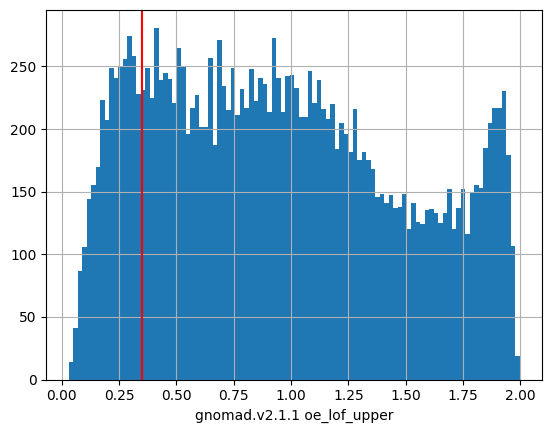

In [500]:
haplo_genes["oe_lof_upper"].hist(bins=100)
plt.xlabel("gnomad.v2.1.1 oe_lof_upper")
plt.axvline(x=0.35, color="red")           

In [501]:
haplo_genes = haplo_genes[haplo_genes.oe_lof_upper<0.35]

In [145]:
haplo_genes["transcript"].to_csv("haplo_transcripts.txt",index=False,header=False)

In [167]:
haplo_transcripts = pd.read_csv("../debora_twins/haplo_transcripts_with_exons.txt", sep="\t")
haplo_transcripts.drop_duplicates(subset=["Gene name",
                                          "Chromosome/scaffold name",
                                          "Transcript start (bp)",
                                          "Transcript end (bp)"],
                                 inplace=True)
haplo_transcripts.head(1)

Gene stable ID Gene stable ID version Transcript stable ID  \
0  ENSG00000099917     ENSG00000099917.17      ENST00000263205   

  Transcript stable ID version  Exon region start (bp)  Exon region end (bp)  \
0           ENST00000263205.11                20551436              20551487   

   Constitutive exon Gene name Chromosome/scaffold name  \
0                  0     MED15                       22   

   Transcript start (bp)  Transcript end (bp)  
0               20507610             20587619

In [148]:
haplo_exons = pd.read_csv("../debora_twins/haplo_exons.txt", sep="\t")
haplo_exons.head(1)

Gene stable ID Gene stable ID version Transcript stable ID  \
0  ENSG00000099917     ENSG00000099917.17      ENST00000263205   

  Transcript stable ID version  Exon region start (bp)  Exon region end (bp)  \
0           ENST00000263205.11                20551436              20551487   

   Constitutive exon Gene name Chromosome/scaffold name  
0                  0     MED15                       22

In [540]:
haplo_transcripts["chrm"] = haplo_transcripts["Chromosome/scaffold name"].apply(lambda x: "chr" + x)
haplo_transcripts_bt = pybedtools.BedTool.from_dataframe(
        haplo_transcripts[["chrm","Transcript start (bp)","Transcript end (bp)","Gene name"]]).sort()

haplo_exons["chrm"] = haplo_exons["Chromosome/scaffold name"].apply(lambda x: "chr" + x)
haplo_exons_bt = pybedtools.BedTool.from_dataframe(
        haplo_exons[["chrm","Exon region start (bp)","Exon region end (bp)","Gene name"]]).sort()


exon_level_SVs = ["DEL","DUP","INS"]

filtered_twins_CNV_bt = pybedtools.BedTool.from_dataframe(
        filtered_twins.query("SV_type in @exon_level_SVs").drop_duplicates(subset=["interval_index"])[
                ["chrm","start","end","interval_index","SV_type","length","caller"]
    ]).sort()

filtered_twins_SVs_bt = pybedtools.BedTool.from_dataframe(
        filtered_twins.query("not (SV_type in @exon_level_SVs)").drop_duplicates(subset=["interval_index"])[
                ["chrm","start","end","interval_index","SV_type","length","caller"]
    ]).sort()


filtered_twins_CNVs_with_closest_haplo_genes = filtered_twins_CNV_bt.closest(
    haplo_exons_bt,d=True
)

filtered_twins_SVs_with_closest_haplo_genes = filtered_twins_SVs_bt.closest(
    haplo_transcripts_bt,d=True
)

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.

<h2> Historical results </h2>

In [236]:
# pd.set_option('display.max_rows', 80)

filtered_twins_with_closest_haplo_genes = pd.concat([
    filtered_twins_CNVs_with_closest_haplo_genes.to_dataframe(),
    filtered_twins_SVs_with_closest_haplo_genes.to_dataframe()
    ]
                                                   ).\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                })
filtered_twins_with_closest_haplo_genes.\
                                drop_duplicates(subset=["chrom","start","end","interval_index","geneName"]).\
                                query("SV_distance==0").\
                                sort_values(by=["SV_distance","chrom","start"])[:980]
#                                query("blockStarts>0 and chrom=='chr6'").

chrom      start        end  interval_index SV_type   SV_len    caller  \
138    chr1  240207634  240207668          292312     DEL       34  delly_sv   
177   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
186   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
195   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
221   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
236   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
252   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
270   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
295   chr10   29430620   37068606          185975     DEL  7637986  delly_sv   
14    chr11     926282     926283            3332     BND        1  delly_sv   
690   chr14   41756234   48370784          295865     DUP  6614550  delly_sv   
704   chr14   41756234   48370784          295865     DUP  6614550  delly_sv   
720   chr14   41756690   48371159          220642     DEL  6614469  delly_sv   
734   chr14   41756690   48371159          220642     DEL  6614469  delly_sv   
50    chr14   79308957   79308958           11723     BND        1  delly_sv   
74    chr17   28085943   28085944           16889     BND        1  delly_sv   
1055  chr18   58985107   58985138          243546     DEL       31  delly_sv   
1115  chr19   42386433   44838890          250278     DEL  2452457  delly_sv   
1124  chr19   42386433   44838890          250278     DEL  2452457  delly_sv   
1133  chr19   42386563   44839096          297304     DUP  2452533  delly_sv   
1142  chr19   42386563   44839096          297304     DUP  2452533  delly_sv   
1199   chr2   31742709   31897834          297501     DUP   155125  delly_sv   
124    chr2  241258372  241258373           22413     BND        1  delly_sv   
1358  chr20   32849655   32849800          263561     DEL      145  delly_sv   
127   chr20   35829829   35829830           23360     BND        1  delly_sv   
128   chr20   53404898   53404899           23750     BND        1  delly_sv   
195    chr4  158878863  158878864          134731     INV        1  delly_sv   
1728   chr5     443203     443257          284460     DEL       54  delly_sv   
2145   chr8   86024870   91831073          300442     DUP  5806203  delly_sv   

     geneChr  geneStart    geneEnd geneName  SV_distance  
138     chr1  240206799  240208732     FMN2            0  
177    chr10   30309801   30313971    MTPAP            0  
186    chr10   30434184   30434378   MAP3K8            0  
195    chr10   32009015   32011516    KIF5B            0  
221    chr10   32268931   32269135     EPC1            0  
236    chr10   32900319   32901635    ITGB1            0  
252    chr10   33177492   33180365     NRP1            0  
270    chr10   34109561   34111562    PARD3            0  
295    chr10   35008551   35010442     CUL2            0  
14     chr11     925870    1012240    AP2A2            0  
690    chr14   45084116   45084249   PRPF39            0  
704    chr14   46839629   46842019    MDGA2            0  
720    chr14   45084116   45084249   PRPF39            0  
734    chr14   46839629   46842019    MDGA2            0  
50     chr14   78403750   79862443    NRXN3            0  
74     chr17   28042677   28196381      NLK            0  
1055   chr18   58983972   58986480   ZNF532            0  
1115   chr19   43622368   43623439    CADM4            0  
1124   chr19   44748708   44749046     BCL3            0  
1133   chr19   43622368   43623439    CADM4            0  
1142   chr19   44748708   44749046     BCL3            0  
1199    chr2   31865060   31868492    MEMO1            0  
124     chr2  241227264  241272886    HDLBP            0  
1358   chr20   32848672   32850405   MAPRE1            0  
127    chr20   35772015   35950370    PHF20            0  
128    chr20   52972358   53495330    TSHZ2            0  
195     chr4

<h1> Genes near by affected-specific (not shared) SVs </h1>

In [546]:
filtered_twins_with_closest_haplo_genes = pd.concat([
    filtered_twins_CNVs_with_closest_haplo_genes.to_dataframe(),
    filtered_twins_SVs_with_closest_haplo_genes.to_dataframe()
    ]
                                                   ).\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                })
filtered_twins_with_closest_haplo_genes.\
                                drop_duplicates(subset=["chrom","start","end","interval_index"]).\
                                query("SV_distance>0").\
                                sort_values(by=["SV_distance","chrom","start"])[:20]
#                                query("blockStarts>0 and chrom=='chr6'").

chrom      start        end  interval_index SV_type  SV_len    caller  \
1974  chr20   63442598   63443039          298176     DUP     441  delly_sv   
3384   chr7  138903813  138903851          178550     DEL      38  delly_sv   
1972  chr20   62325115   62325116           53549     INS       1  delly_sv   
3462   chr8  142520383  142520487          185735     DEL     104  delly_sv   
1292  chr10   91936406   91936407           52101     INS       1  delly_sv   
3317   chr6   72100629   72100630           54480     INS       1  delly_sv   
5      chr1   19143247   19143280          199725     DEL      33  delly_sv   
1109   chr1  246852349  246852389          169553     DEL      40  delly_sv   
1382  chr12  124438708  124439138          295357     DUP     430  delly_sv   
2696   chr3  183802535  183802536           53904     INS       1  delly_sv   
3373   chr7   74361176   74361177           54701     INS       1  delly_sv   
3413   chr8   42327814   42328215          181544     DEL     401  delly_sv   
3338   chr6  165334286  165334479          170766     DEL     193  delly_sv   
1285  chr10   77041144   77041464          199799     DEL     320  delly_sv   
1855  chr19   29825821   29826251          248882     DEL     430  delly_sv   
1996  chr21   43961491   43961526          267520     DEL      35  delly_sv   
3548   chrX   70906075   70906117          195647     DEL      42  delly_sv   
1571  chr14   91507640   91507641           52733     INS       1  delly_sv   
1595  chr15   62773065   62773305          225871     DEL     240  delly_sv   
2759   chr5    1276654    1276708          284565     DEL      54  delly_sv   

     geneChr  geneStart    geneEnd  geneName  SV_distance  
1974   chr20   63442406   63442531     KCNQ2           68  
3384    chr7  138903588  138903736  KIAA1549           78  
1972   chr20   62325316   62325546     LAMA5          201  
3462    chr8  142520823  142520925    ADGRB1          337  
1292   chr10   91935657   91935780     BTAF1          627  
3317    chr6   72099975   72099986     RIMS1          644  
5       chr1   19143980   19144091      UBR4          701  
1109    chr1  246853091  246853299    AHCTF1          703  
1382   chr12  124437930  124437996     NCOR2          713  
2696    chr3  183803256  183803335    YEATS2          721  
3373    chr7   74360175   74360278     CLIP2          899  
3413    chr8   42329124   42329214     IKBKB          910  
3338    chr6  165327289  165333127    PDE10A         1160  
1285   chr10   77039528   77039637    KCNMA1         1508  
1855   chr19   29823655   29824312     CCNE1         1510  
1996   chr21   43959634   43959859    AGPAT3         1633  
3548    chrX   70907753   70907810     TEX11         1637  
1571   chr14   91509506   91510144   PPP4R3A         1866  
1595   chr15   62770964   62771134      TLN2         1932  
2759    chr5    1278641    1278796      TERT         1934

In [ ]:
# chr19	42386563	44839096 - large mosaic duplication???
# chr20	32849655	32849800 - MAPRE1 gene. The region is very different between case and control

# EB1 levels are elevated in ascorbic Acid (AA)-stimulated osteoblasts and mediate cell-cell adhesion-induced osteoblast differentiation
# https://pubmed.ncbi.nlm.nih.gov/23740245/

# !!!! 100 vert convserved 5'-UTR!
# http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr20%3A32844913%2D32851437&hgsid=1658088202_WV1tAzmVgs6asBwTmGIFQa7jqAWf

# example of potentially mosaic event (not within haplo-gene):
# chr11	65542034	65542066


In [140]:
filtered_twins_with_closest_haplo_genes.to_dataframe().\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                })["SV_type"].value_counts()

DEL    1769
BND     708
INS     362
DUP     130
INV      60
Name: SV_type, dtype: int64

<h1> Debora genes</h1>

In [583]:
debora_genes = pd.read_csv("../debora_twins/Debora_genes_hg38",sep="\t", header=None,
                           names=["Gene name","chrm","Transcript start (bp)","Transcript end (bp)"])
debora_genes.head(1)

debora_genes_bt = pybedtools.BedTool.from_dataframe(
         debora_genes[["chrm","Transcript start (bp)","Transcript end (bp)","Gene name"]]).sort()

filtered_twins_bt = pybedtools.BedTool.from_dataframe(
         filtered_twins.drop_duplicates(subset=["interval_index"])[
                 ["chrm","start","end","interval_index","SV_type","length","caller"]
     ]).sort()

filtered_twins_bt = filtered_twins_bt.closest(
    debora_genes_bt,d=True
)

filtered_twins_with_closest_debora_genes = filtered_twins_bt.to_dataframe().\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                })
filtered_twins_with_closest_debora_genes.query("SV_distance>=0").sort_values(by=["SV_distance"])

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
***** WARNING: File /tmp/pybedtools.i2mqayj3.tmp has inconsistent naming convention for record:
chr1	165201867	165356715	LMX1A

***** WARNING: File /tmp/pybedtools.i2mqayj3.tmp has inconsistent naming convention for record:
chr1	165201867	165356715	LMX1A



chrom      start        end  interval_index SV_type    SV_len    caller  \
33    chr1  159768538  224339875          298925     DUP  64571337  delly_sv   
522   chr2  202366549  202366586          259607     DEL        37  delly_sv   
114  chr10  101728698  101728699            2672     BND         1  delly_sv   
635   chr3   14321887   14321918          272014     DEL        31  delly_sv   
778   chr5  143461848  143461882          289352     DEL        34  delly_sv   
..     ...        ...        ...             ...     ...       ...       ...   
465   chr2    2856690    2856721          252609     DEL        31  delly_sv   
464   chr2    1679570    1679869          297460     DUP       299  delly_sv   
463   chr2    1596066    1597910          297457     DUP      1844  delly_sv   
462   chr2    1522984    1535315          252532     DEL     12331  delly_sv   
461   chr2    1208249    1208322          252507     DEL        73  delly_sv   

    geneChr  geneStart    geneEnd geneName  SV_distance  
33     chr1  165201867  165356715    LMX1A            0  
522    chr2  202376327  202567749    BMPR2         9742  
114   chr10  101770109  101780369     FGF8        41411  
635    chr3   13816258   13880071    WNT7A       441817  
778    chr5  142592178  142698070     FGF1       763779  
..      ...        ...        ...      ...          ...  
465    chr2  176087487  176095944   HOXD13    173230767  
464    chr2  176087487  176095944   HOXD13    174407619  
463    chr2  176087487  176095944   HOXD13    174489578  
462    chr2  176087487  176095944   HOXD13    174552173  
461    chr2  176087487  176095944   HOXD13    174879166  

[700 rows x 12 columns]

<h1> Twins - mosaic level </h1>

In [242]:
found_in_both_twins_case_by_any_method = \
(
    (pd.isna(pv["FILTERbool","delly_sv"][cases_twins]).sum(axis=1)==0) + \
    (pd.isna(pv["FILTERbool","cue"][cases_twins]).sum(axis=1)==0)
)

filt2 = not_found_in_controls & found_in_both_twins_case_by_any_method

twins_shared = SVs_bed_combined_annotated_Ana\
                        .drop_duplicates(subset="interval_index")\
                        .set_index("interval_index")\
                        .loc[pv[filt2].index.values]\
                        .reset_index()
twins_shared

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


interval_index               chrm      start        end SV_type  \
0                662  HLA-DRB1*13:01:01       3072       3073     BND   
1                776              chr10    3096785    3096786     BND   
2                812              chr10    4961553    4961554     BND   
3               1035              chr10   15484667   15484668     BND   
4               1189              chr10   22290887   22290888     BND   
...              ...                ...        ...        ...     ...   
3836          301952              chr10   97251290   97251792     DUP   
3837          301989              chr10  127797429  127797689     DUP   
3838          302000              chr10  130790015  130790711     DUP   
3839          302021              chr10  132444025  132444284     DUP   
3840          302103              chr11   39759506   40042435     DUP   

       FILTER  original_index  length    caller                  sample  \
0        PASS           27288       1  delly_sv  2030005417_GRV_8GjHK9a   
1        PASS            9736       1  delly_sv  2030005417_GRV_8GjHK9a   
2     LowQual            9757       1  delly_sv  2030005417_GRV_8GjHK9a   
3     LowQual            9848       1  delly_sv  2030005417_GRV_8GjHK9a   
4     LowQual            9883       1  delly_sv  2030005417_GRV_8GjHK9a   
...       ...             ...     ...       ...                     ...   
3836     PASS           11077     502  delly_sv  2030005417_GRV_8GjHK9a   
3837  LowQual           11220     260  delly_sv  2030005417_GRV_8GjHK9a   
3838     PASS           11243     696  delly_sv  2030005417_GRV_8GjHK9a   
3839  LowQual           11277     259  delly_sv  2030005417_GRV_8GjHK9a   
3840  LowQual           11571  282929  delly_sv  2030005417_GRV_8GjHK9a   

                sample_short  FILTERbool  
0     2030005417_GRV_8GjHK9a        True  
1     2030005417_GRV_8GjHK9a        True  
2     2030005417_GRV_8GjHK9a       False  
3     2030005417_GRV_8GjHK9a       False  
4     2030005417_GRV_8GjHK9a       False  
...                      ...         ...  
3836  2030005417_GRV_8GjHK9a        True  
3837  2030005417_GRV_8GjHK9a       False  
3838  2030005417_GRV_8GjHK9a        True  
3839  2030005417_GRV_8GjHK9a       False  
3840  2030005417_GRV_8GjHK9a       False  

[3841 rows x 12 columns]

In [259]:
gl_affected = SVs[twin_affected[0]+":delly_sv"].extract_format("GL")
gl_normal = SVs[twin_unaffected[0]+"-027:delly_sv"].extract_format("GL")

In [270]:
gl_affected_hz = gl_affected.iltwin_affectedoc[:,0].apply(lambda x: float(x.split(",")[1]))
gl_normal_hz = gl_normal.iloc[:,0].apply(lambda x: float(x.split(",")[1]))

In [273]:
gl = {}
gl["2030005417_GRV_8GjHK9a"] = gl_affected_hz
gl["20210442-027"] = gl_normal_hz

<Axes: >

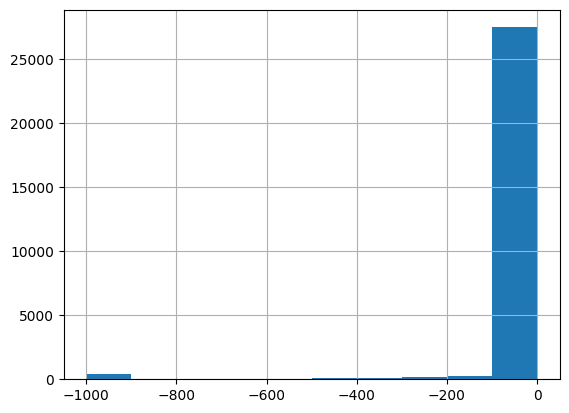

In [285]:
gl["20210442-027"].hist()

In [289]:
!cat ../debora_twins/20210442-027/delly/delly.sv.vcf | grep "##FORMAT" | grep "GL"

##FORMAT=<ID=GL,Number=G,Type=Float,Description="Log10-scaled genotype likelihoods for RR,RA,AA genotypes">


In [345]:
!tail -1 ../debora_twins/20210442-027/reports/svs.vcf 

chr21	44551338	INV	N	<INV>	54	PASS	END=44702386;SVTYPE=INV;SVLEN=151049	GT	0/1


In [352]:
tmp = SVs_bed_combined_annotated.query("caller=='delly_sv'").set_index(["interval_index","sample"]).sort_index()
#tmp.loc[(220616,"19412RT-Gen005-PCRfree-30X"),:].original_index.values
def f(ii):
    result = [ii]
    for s in ["2030005417_GRV_8GjHK9a","20210442-027"]:
        try:
            s_ids = tmp.loc[(ii,s),"original_index"].values
        except KeyError:
            result.append(None)
            continue
        result.append(gl[s].iloc[s_ids].max())
    return result

all_results = []
for ii in tqdm(twins_shared.interval_index.unique()):
    all_results.append(f(ii))

  0%|          | 0/3841 [00:00<?, ?it/s]

In [362]:
all_results = all_results[~pd.isna(all_results).max(axis=1)]

Text(0.5, 1.0, 'log10 GL for Hetz')

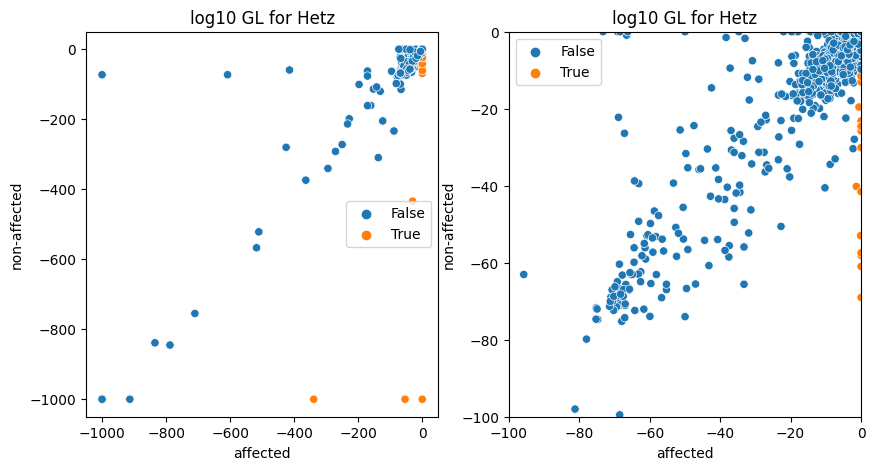

In [506]:
import seaborn as sns
import matplotlib.pyplot as plt

all_results = np.array(all_results)

suspecious = ((all_results[:,2] / (all_results[:,1] - 1) > 10) | \
                ((all_results[:,1]>-400) & (all_results[:,2]<-600))
             ) 

plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
sns.scatterplot(x=all_results[:,1],y=all_results[:,2], hue = suspecious, axes = ax)
plt.xlabel("affected")
plt.ylabel("non-affected")
plt.title("log10 GL for Hetz")

ax = plt.subplot(1,2,2)
sns.scatterplot(x=all_results[:,1],y=all_results[:,2], hue = suspecious, axes = ax)
plt.xlabel("affected")
plt.ylabel("non-affected")
plt.xlim(-100,0)
plt.ylim(-100,0)
plt.title("log10 GL for Hetz")

In [364]:
suspecious_ids = all_results[suspecious][:,0]
SVs_bed_combined_annotated.query("interval_index in @suspecious_ids")

chrm  \
name                                                                      
3767:4087:2030005417_GRV_8GjHK9a:delly_sv                          chr4   
12659:13586:2030005417_GRV_8GjHK9a:delly_sv                       chr13   
18137:19430:2030005417_GRV_8GjHK9a:delly_sv                       chr21   
19670:21026:2030005417_GRV_8GjHK9a:delly_sv                        chrY   
20162:21601:2030005417_GRV_8GjHK9a:delly_sv     chr17_KI270729v1_random   
22011:23472:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707626v1_decoy   
22012:23473:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707626v1_decoy   
22383:23844:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707828v1_decoy   
22625:24086:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707895v1_decoy   
22656:24117:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
22663:24124:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
22673:24134:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
22687:24148:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
22715:24178:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
22721:24185:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
23011:24500:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707896v1_decoy   
23161:24656:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707897v1_decoy   
23174:24669:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707902v1_decoy   
23199:24694:2030005417_GRV_8GjHK9a:delly_sv      chrUn_KN707914v1_decoy   
25151:26647:2030005417_GRV_8GjHK9a:delly_sv  chrUn_JTFH01001797v1_decoy   
25379:26876:2030005417_GRV_8GjHK9a:delly_sv  chrUn_JTFH01001899v1_decoy   
27417:1602:2030005417_GRV_8GjHK9a:delly_sv                         chr2   
3911:4251:20210442-027:delly_sv                                    chr4   
13065:14046:20210442-027:delly_sv                                 chr13   
18849:20200:20210442-027:delly_sv                                 chr21   
20477:21896:20210442-027:delly_sv                                  chrY   
21015:22511:20210442-027:delly_sv               chr17_KI270729v1_random   
22972:24493:20210442-027:delly_sv                chrUn_KN707626v1_decoy   
23360:24881:20210442-027:delly_sv                chrUn_KN707828v1_decoy   
23591:25112:20210442-027:delly_sv                chrUn_KN707895v1_decoy   
23618:25140:20210442-027:delly_sv                chrUn_KN707896v1_decoy   
23627:25149:20210442-027:delly_sv                chrUn_KN707896v1_decoy   
23646:25169:20210442-027:delly_sv                chrUn_KN707896v1_decoy   
23669:25194:20210442-027:delly_sv                chrUn_KN707896v1_decoy   
23924:25477:20210442-027:delly_sv                chrUn_KN707896v1_decoy   
24078:25634:20210442-027:delly_sv                chrUn_KN707897v1_decoy   
24093:25649:20210442-027:delly_sv                chrUn_KN707902v1_decoy   
24122:25678:20210442-027:delly_sv                chrUn_KN707914v1_decoy   
26301:27858:20210442-027:delly_sv            chrUn_JTFH01001797v1_decoy   
26538:28097:20210442-027:delly_sv            chrUn_JTFH01001899v1_decoy   
28700:1721:20210442-027:delly_sv                                   chr2   

                                                 start        end SV_type  \
name                                                                        
3767:4087:2030005417_GRV_8GjHK9a:delly_sv     49107509   49107550     DEL   
12659:13586:2030005417_GRV_8GjHK9a:delly_sv   28819611   28819612     BND   
18137:19430:2030005417_GRV_8GjHK9a:delly_sv   10698669   10698670     INS   
19670:21026:2030005417_GRV_8GjHK9a:delly_sv   11539250   11539281     DEL   
20162:21601:2030005417_GRV_8GjHK9a:delly_sv       3029       3030     INS   
22011:23472:2030005417_GRV_8GjHK9a:delly_sv       4964       4965     BND   
22012:23473:2030005417_GRV_8GjHK9a:delly_sv       5445       5446     BND   
22383:23844:2030005417_GRV_8GjHK9a:delly_sv        704       2152     DEL   
22625:24086:2030005417_GRV_8GjHK9a:delly_sv          2          3     B

In [507]:
len(suspecious_ids)

19

<h1>SNVs</h1>

In [375]:
affected = pyvcf.VcfFrame.from_file("../../../venus/mar/share_pesquisa/debora_veniamin/GemeosDiscordantes_TAOS/F018233-1/originais/2030005417_GRV.hard-filtered.vcf.gz")
affected

In [381]:
nonaffectged = pyvcf.VcfFrame.from_file("../../../venus/mar/share_pesquisa/debora_veniamin/GemeosDiscordantes_TAOS/F018233-2/originais/20210442-027.hard-filtered.vcf.gz")
nonaffectged

In [426]:
def getAD(x,sname):
    AD_id = x["FORMAT"].split(":").index("AD")
    return x[sname].split(":")[AD_id]
    
nonaffectged.df["AD"] = nonaffectged.df.progress_apply(getAD, axis="columns", sname="20210442-027")

  0%|          | 0/5214114 [00:00<?, ?it/s]

In [427]:
nonaffectged.df

CHROM    POS ID REF                ALT   QUAL  \
0                     chr1  10146  .  AC                  A  27.06   
1                     chr1  10230  .  AC                  A  41.19   
2                     chr1  10247  .  TA                  T  49.02   
3                     chr1  10254  .  TA                  T  51.37   
4                     chr1  10327  .   T                  C   7.43   
...                    ...    ... ..  ..                ...    ...   
5214109  HLA-DRB1*10:01:01   2359  .   G                  A   7.81   
5214110  HLA-DRB1*13:01:01   2964  .   T  TTTTATTTATTTATTTA  49.67   
5214111  HLA-DRB1*13:01:01   3039  .   T                  C  28.14   
5214112  HLA-DRB1*13:01:01   3228  .   A                  G  20.04   
5214113  HLA-DRB1*14:05:01   2747  .   G                  A   7.81   

                             FILTER  \
0                              PASS   
1                              PASS   
2                              PASS   
3                              PASS   
4                 DRAGENSnpHardQUAL   
...                             ...   
5214109  DRAGENSnpHardQUAL;LowDepth   
5214110                        PASS   
5214111                        PASS   
5214112                        PASS   
5214113  DRAGENSnpHardQUAL;LowDepth   

                                                      INFO  \
0        AC=1;AF=0.500;AN=2;DP=41;FS=2.077;MQ=19.12;MQR...   
1        AC=2;AF=1.000;AN=2;DP=23;FS=0.000;MQ=17.09;MQR...   
2        AC=2;AF=1.000;AN=2;DP=25;FS=0.000;MQ=16.64;MQR...   
3        AC=2;AF=1.000;AN=2;DP=26;FS=0.000;MQ=16.31;MQR...   
4        AC=1;AF=0.500;AN=2;DP=34;FS=3.882;MQ=20.75;MQR...   
...                                                    ...   
5214109  AC=2;AF=1.000;AN=2;DP=1;FS=0.000;MQ=19.00;QD=7...   
5214110  AC=1;AF=0.500;AN=2;DP=33;FS=0.000;MQ=146.12;MQ...   
5214111  AC=1;AF=0.500;AN=2;DP=21;FS=0.000;MQ=106.18;MQ...   
5214112  AC=1;AF=0.500;AN=2;DP=32;FS=0.000;MQ=31.94;MQR...   
5214113  AC=2;AF=1.000;AN=2;DP=1;FS=0.000;MQ=19.00;QD=7...   

                                           FORMAT  \
0        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
1        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
2        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
3        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
4        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
...                                           ...   
5214109  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5214110  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5214111  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5214112  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5214113  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   

                                              20210442-027 AC    AD  
0        0/1:9,9:0.500:18:5,5:4,4:27:56,0,39:2.7064e+01...  1   9,9  
1        1/1:3,10:0.769:13:1,2:2,8:10:74,13,0:4.1191e+0...  2  3,10  
2        1/1:2,12:0.857:14:1,4:1,8:18:82,21,0:4.9016e+0...  2  2,12  
3        1/1:2,13:0.867:15:1,4:1,9:20:84,23,0:5.1370e+0...  2  2,13  
4        0/1:9,13:0.591:22:4,3:5,10:7:41,0,14:7.4254e+0...  1  9,13  
...                                                    ... ..   ...  
5214109  1/1:0,1:1.000:1:0,1:0,0:2:42,3,0:7.8093e+00,3....  2   0,1  
5214110  0/1:5,4:0.444:9:2,2:3,2:48:61,0,49:4.9666e+01,...  1   5,4  
5214111  0/1:5,2:0.286:7:2,1:3,1:28:63,0,46:2.8137e+01,...  1   5,2  
5214112  0/1:2,2:0.500:4:2,1:0,1:20:55,0,37:2.0044e+01,...  1   2,2  
5214113  1/1:0,1:1.000:1:0,1:0,0:2:42,3,0:7.8124e+00,3....  2   0,1  

[5214114 rows x 12 columns]

In [430]:
affected.df["AD"] = affected.df.progress_apply(getAD, axis="columns", sname="2030005417_GRV")
affected.df

  0%|          | 0/5220308 [00:00<?, ?it/s]

CHROM    POS ID REF          ALT   QUAL  \
0                        chr1  10230  .  AC            A  29.32   
1                        chr1  10247  .  TA            T  28.05   
2                        chr1  10250  .   A            C  13.01   
3                        chr1  10254  .  TA            T  30.34   
4                        chr1  10257  .   A            C   4.56   
...                       ...    ... ..  ..          ...    ...   
5220303  HLA-DQB1*03:03:02:02   1901  .   C  CGGGCAGGGCT  16.11   
5220304     HLA-DRB1*08:03:02   2789  .   T        TTTTA   9.96   
5220305     HLA-DRB1*08:03:02  12936  .   C            G   7.79   
5220306     HLA-DRB1*11:01:02   4583  .   A           AT   8.08   
5220307     HLA-DRB1*11:04:01   4583  .   A           AT  33.78   

                    FILTER                                               INFO  \
0                     PASS  AC=1;AF=0.500;AN=2;DP=60;FS=18.485;MQ=16.48;MQ...   
1                     PASS  AC=1;AF=0.500;AN=2;DP=53;FS=2.147;MQ=17.03;MQR...   
2                     PASS  AC=1;AF=0.500;AN=2;DP=52;FS=0.000;MQ=17.19;MQR...   
3                     PASS  AC=1;AF=0.500;AN=2;DP=51;FS=2.318;MQ=17.26;MQR...   
4        DRAGENSnpHardQUAL  AC=1;AF=0.500;AN=2;DP=52;FS=2.611;MQ=17.11;MQR...   
...                    ...                                                ...   
5220303               PASS  AC=2;AF=1.000;AN=2;DP=12;FS=0.000;MQ=250.00;QD...   
5220304               PASS  AC=1;AF=0.500;AN=2;DP=27;FS=0.000;MQ=98.21;QD=...   
5220305  DRAGENSnpHardQUAL  AC=2;AF=1.000;AN=2;DP=3;FS=0.000;MQ=14.00;QD=2...   
5220306               PASS  AC=2;AF=1.000;AN=2;DP=22;FS=0.000;MQ=28.00;QD=...   
5220307               PASS  AC=2;AF=1.000;AN=2;DP=25;FS=0.000;MQ=28.50;QD=...   

                                           FORMAT  \
0        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
1        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
2        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
3        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
4        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
...                                           ...   
5220303  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5220304  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5220305  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5220306  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5220307  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   

                                            2030005417_GRV AC     AD  
0        0/1:13,36:0.735:49:6,13:7,23:18:58,0,16:2.9323...  1  13,36  
1        0/1:22,19:0.463:41:9,5:13,14:28:57,0,35:2.8046...  1  22,19  
2        0/1:26,16:0.381:42:5,8:21,8:13:48,0,35:1.3007e...  1  26,16  
3        0/1:18,21:0.538:39:7,6:11,15:29:59,0,34:3.0338...  1  18,21  
4        0/1:34,10:0.227:44:11,4:23,6:5:37,0,35:4.5581e...  1  34,10  
...                                                    ... ..    ...  
5220303  1/1:0,1:1.000:1:0,1:0,0:3:45,3,0:1.6113e+01,3....  2    0,1  
5220304  0/1:0,1:1.000:1:0,1:0,0:3:38,3,0:9.9637e+00,3....  1    0,1  
5220305  1/1:0,1:1.000:1:0,0:0,1:2:42,3,0:7.7875e+00,3....  2    0,1  
5220306  1/1:0,1:1.000:1:0,1:0,0:2:31,3,0:8.0761e+00,3....  2    0,1  
5220307  1/1:0,2:1.000:2:0,0:0,2:5:59,6,0:3.3776e+01,4....  2    0,2  

[5220308 rows x 12 columns]

In [433]:
def AD2num(x):
    return max(map(int,x.split(",")[1:]))

affected.df["cALT"] = affected.df["AD"].apply(AD2num)
nonaffectged.df["cALT"] = nonaffectged.df["AD"].apply(AD2num)

In [438]:
affected.df["cALT"]

0          36
1          19
2          16
3          21
4          10
           ..
5220303     1
5220304     1
5220305     1
5220306     1
5220307     2
Name: cALT, Length: 5220308, dtype: int64

In [439]:
merged = pd.merge(left=affected.df, right=nonaffectged.df,
                  on=["CHROM","POS","ALT","REF"],how="outer",
                  suffixes=["_affected","_non_affected"],
                  indicator=True
                 )
merged

CHROM    POS ID_affected REF                ALT  \
0                     chr1  10230           .  AC                  A   
1                     chr1  10247           .  TA                  T   
2                     chr1  10250           .   A                  C   
3                     chr1  10254           .  TA                  T   
4                     chr1  10257           .   A                  C   
...                    ...    ...         ...  ..                ...   
5433684  HLA-DRB1*10:01:01   2359         NaN   G                  A   
5433685  HLA-DRB1*13:01:01   2964         NaN   T  TTTTATTTATTTATTTA   
5433686  HLA-DRB1*13:01:01   3039         NaN   T                  C   
5433687  HLA-DRB1*13:01:01   3228         NaN   A                  G   
5433688  HLA-DRB1*14:05:01   2747         NaN   G                  A   

        QUAL_affected    FILTER_affected  \
0               29.32               PASS   
1               28.05               PASS   
2               13.01               PASS   
3               30.34               PASS   
4                4.56  DRAGENSnpHardQUAL   
...               ...                ...   
5433684           NaN                NaN   
5433685           NaN                NaN   
5433686           NaN                NaN   
5433687           NaN                NaN   
5433688           NaN                NaN   

                                             INFO_affected  \
0        AC=1;AF=0.500;AN=2;DP=60;FS=18.485;MQ=16.48;MQ...   
1        AC=1;AF=0.500;AN=2;DP=53;FS=2.147;MQ=17.03;MQR...   
2        AC=1;AF=0.500;AN=2;DP=52;FS=0.000;MQ=17.19;MQR...   
3        AC=1;AF=0.500;AN=2;DP=51;FS=2.318;MQ=17.26;MQR...   
4        AC=1;AF=0.500;AN=2;DP=52;FS=2.611;MQ=17.11;MQR...   
...                                                    ...   
5433684                                                NaN   
5433685                                                NaN   
5433686                                                NaN   
5433687                                                NaN   
5433688                                                NaN   

                                  FORMAT_affected  \
0        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
1        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
2        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
3        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
4        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
...                                           ...   
5433684                                       NaN   
5433685                                       NaN   
5433686                                       NaN   
5433687                                       NaN   
5433688                                       NaN   

                                            2030005417_GRV  ...  \
0        0/1:13,36:0.735:49:6,13:7,23:18:58,0,16:2.9323...  ...   
1        0/1:22,19:0.463:41:9,5:13,14:28:57,0,35:2.8046...  ...   
2        0/1:26,16:0.381:42:5,8:21,8:13:48,0,35:1.3007e...  ...   
3        0/1:18,21:0.538:39:7,6:11,15:29:59,0,34:3.0338...  ...   
4        0/1:34,10:0.227:44:11,4:23,6:5:37,0,35:4.5581e...  ...   
...                                                    ...  ...   
5433684                                                NaN  ...   
5433685                                                NaN  ...   
5433686                                                NaN  ...   
5433687                                                NaN  ...   
5433688                                                NaN  ...   

        ID_non_affected QUAL_non_affected         FILTER_non_affected  \
0                     .             41.19                        PASS   
1                     .             49.02                        PASS   
2                   NaN               NaN                         NaN   
3                     .             51.37                        PASS   
4                   NaN               NaN                         NaN   
..

In [441]:
merged.loc[:,"cALT_affected"] = merged["cALT_affected"].fillna(value=0)
merged.loc[:,"cALT_non_affected"] = merged["cALT_non_affected"].fillna(value=0)

In [442]:
merged["cALT_affected"].values

array([36., 19., 16., ...,  0.,  0.,  0.])

In [443]:
merged[["cALT_affected","cALT_non_affected"]].values.max(axis=1)

array([36., 19., 16., ...,  2.,  2.,  1.])

In [444]:
merged_filtered = merged[merged[["cALT_affected","cALT_non_affected"]].values.max(axis=1)>2]
len(merged_filtered), len(merged)

(5277292, 5433689)

(0.0, 100.0)

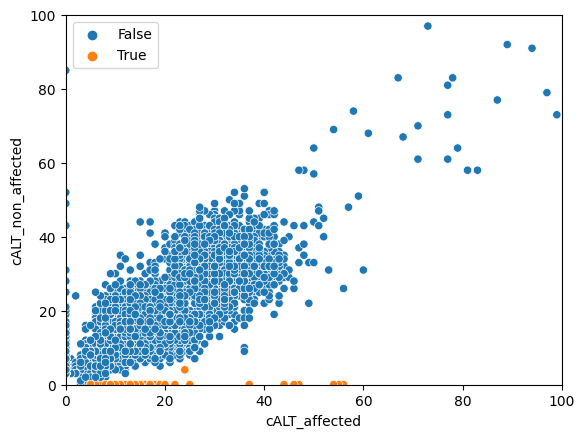

In [453]:
SNV_susp = (merged_filtered["cALT_affected"] / (merged_filtered["cALT_non_affected"] + 1)) > 4
subset = 1000
sns.scatterplot(data=merged_filtered.iloc[::subset], x="cALT_affected",y="cALT_non_affected",
               hue=SNV_susp[::subset])
plt.xlim(0,100)
plt.ylim(0,100)

In [549]:
merged_filtered[SNV_susp]["_merge"].value_counts()

left_only     112519
both             907
right_only         0
Name: _merge, dtype: int64

In [553]:
affected.df[SNV_susp[:len(affected.df)].values]

CHROM        POS ID REF ALT    QUAL             FILTER  \
2        chr1      10250  .   A   C   13.01               PASS   
4        chr1      10257  .   A   C    4.56  DRAGENSnpHardQUAL   
5        chr1      10279  .   T   C    9.98  DRAGENSnpHardQUAL   
6        chr1      10285  .   T   C   26.83               PASS   
8        chr1      10333  .  CT   C   38.00               PASS   
...       ...        ... ..  ..  ..     ...                ...   
5130143  chrX  118507134  .   G   T  103.26               PASS   
5130154  chrX  118528489  .   C   T   89.13               PASS   
5130212  chrX  118616559  .   T   G  101.16               PASS   
5130216  chrX  118618780  .   A  AT   98.11               PASS   
5130230  chrX  118645419  .   C   T  119.23               PASS   

                                                      INFO  \
2        AC=1;AF=0.500;AN=2;DP=52;FS=0.000;MQ=17.19;MQR...   
4        AC=1;AF=0.500;AN=2;DP=52;FS=2.611;MQ=17.11;MQR...   
5        AC=1;AF=0.500;AN=2;DP=53;FS=2.695;MQ=18.43;MQR...   
6        AC=1;AF=0.500;AN=2;DP=56;FS=0.000;MQ=19.62;MQR...   
8        AC=1;AF=0.500;AN=2;DP=48;FS=0.000;MQ=20.80;MQR...   
...                                                    ...   
5130143  AC=1;AF=1.000;AN=1;DP=19;FS=0.000;MQ=250.00;QD...   
5130154  AC=1;AF=1.000;AN=1;DP=14;FS=0.000;MQ=250.00;QD...   
5130212  AC=1;AF=1.000;AN=1;DP=18;FS=0.000;MQ=250.00;QD...   
5130216  AC=1;AF=1.000;AN=1;DP=18;FS=0.000;MQ=250.00;QD...   
5130230  AC=1;AF=1.000;AN=1;DP=23;FS=0.000;MQ=228.24;QD...   

                                           FORMAT  \
2        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
4        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
6        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
8        GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
...                                           ...   
5130143  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5130154  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5130212  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5130216  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5130230  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   

                                            2030005417_GRV AC     AD  cALT  
2        0/1:26,16:0.381:42:5,8:21,8:13:48,0,35:1.3007e...  1  26,16    16  
4        0/1:34,10:0.227:44:11,4:23,6:5:37,0,35:4.5581e...  1  34,10    10  
5        0/1:26,13:0.333:39:4,3:22,10:10:44,0,38:9.9842...  1  26,13    13  
6        0/1:17,22:0.564:39:4,5:13,17:26:62,0,32:2.6830...  1  17,22    22  
8        0/1:18,18:0.500:36:4,3:14,15:36:59,0,38:3.8001...  1  18,18    18  
...                                                    ... ..    ...   ...  
5130143  1:0,18:1.000:18:0,6:0,12:103:138,0:1.0326e+02,...  1   0,18    18  
5130154  1:0,13:1.000:13:0,3:0,10:89:124,0:8.9130e+01,0...  1   0,13    13  
5130212  1:0,17:1.000:17:0,10:0,7:101:136,0:1.0116e+02,...  1   0,17    17  
5130216  1:0,16:1.000:16:0,9:0,7:98:126,0:9.8106e+01,0....  1   0,16    16  
5130230  1:0,23:1.000:23:0,9:0,14:119:154,0:1.1923e+02,...  1   0,23    23  

[113426 rows x 13 columns]

In [563]:
filtered_vcf_formated = merged_filtered[SNV_susp]\
                .rename(columns={v:v.split("_affected")[0] for v in merged_filtered.columns.values})[
                [i for i in affected.df.columns.values if not i in ["AC","AD","cALT"]]                   
]

In [564]:
filtered_vcf_formated = pyvcf.VcfFrame (df = filtered_vcf_formated,
                meta = affected.meta)
filtered_vcf_formated.to_file("all_affectedOnly_variants.vcf")

In [454]:
merged_filtered[SNV_susp].sort_values(by="cALT_affected", ascending=False)

CHROM        POS ID_affected REF             ALT QUAL_affected  \
5159477   chrM       3106           .  CN               C             .   
4376317  chr17   26866800           .   C               T        824.28   
5158232   chrY   11295489           .   T               C        860.95   
4376316  chr17   26866790           .   A               G        715.80   
4376315  chr17   26866787           .   A               C        593.88   
...        ...        ...         ...  ..             ...           ...   
2778475   chr9   60570833           .   T               C         11.50   
4858795  chr20   61641952           .   T               A          9.30   
2778666   chr9   60607955           .   T               C          8.61   
3975540  chr14   84113545           .   C  CTTTTTT,CTTTTT         79.39   
1021108   chr3  118562760           .   G               T         35.97   

           FILTER_affected                                      INFO_affected  \
5159477               PASS  DP=4091;MQ=60.00;LOD=13603.32;FractionInformat...   
4376317               PASS  AC=2;AF=1.000;AN=2;DP=445;FS=0.000;MQ=87.12;MQ...   
5158232               PASS  AC=1;AF=1.000;AN=1;DP=417;FS=4.435;MQ=107.00;M...   
4376316               PASS  AC=2;AF=1.000;AN=2;DP=419;FS=2.272;MQ=90.51;MQ...   
4376315               PASS  AC=2;AF=1.000;AN=2;DP=413;FS=1.267;MQ=90.99;MQ...   
...                    ...                                                ...   
2778475               PASS  AC=1;AF=0.500;AN=2;DP=9;FS=0.000;MQ=8.85;MQRan...   
4858795  DRAGENSnpHardQUAL  AC=1;AF=0.500;AN=2;DP=16;FS=6.117;MQ=18.49;MQR...   
2778666  DRAGENSnpHardQUAL  AC=1;AF=0.500;AN=2;DP=14;FS=10.925;MQ=14.28;MQ...   
3975540               PASS  AC=1,1;AF=0.500,0.500;AN=2;DP=13;FS=0.000;MQ=2...   
1021108               PASS  AC=1;AF=0.500;AN=2;DP=29;FS=2.141;MQ=221.84;MQ...   

                                     FORMAT_affected  \
5159477               GT:SQ:AD:AF:F1R2:F2R1:DP:SB:MB   
4376317     GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
5158232     GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
4376316  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB:PS   
4376315     GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
...                                              ...   
2778475  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB:PS   
4858795     GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
2778666     GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
3975540     GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB   
1021108  GT:AD:AF:DP:F1R2:F2R1:GQ:PL:GP:PRI:SB:MB:PS   

                                            2030005417_GRV  ...  \
5159477  0/1:13603.32:0,3894:1.000:0,1919:0,1975:3894:0...  ...   
4376317  1/1:28,402:0.935:430:17,197:11,205:450:862,780...  ...   
5158232  1:4,372:0.989:376:1,182:3,190:450:896,0:4.5000...  ...   
4376316  1|1:32,369:0.920:401:18,183:14,186:450:754,673...  ...   
4376315  1/1:43,352:0.891:395:23,173:20,179:450:632,551...  ...   
...                                                    ...  ...   
2778475  0|1:4,5:0.556:9:2,3:2,2:10:46,0,11:1.1498e+01,...  ...   
4858795  0/1:11,5:0.312:16:3,3:8,2:9:44,0,30:9.2992e+00...  ...   
2778666  0/1:7,5:0.417:12:2,4:5,1:9:43,0,29:8.6067e+00,...  ...   
3975540  1/2:0,3,5:0.375,0.625:8:0,1,2:0,2,3:4:85,74,49...  ...   
1021108  0|1:16,5:0.238:21:6,2:10,3:36:71,0,50:3.5975e+...  ...   

        ID_non_affected QUAL_non_affected  FILTER_non_affected  \
5159477             NaN               NaN                  NaN   
4376317             NaN               NaN                  NaN   
5158232             NaN               NaN                  NaN   
4376316             NaN               NaN                  NaN   
4376315             NaN               NaN                  NaN   
...                 ...               ...                  ...   
2778475             NaN               NaN                  NaN   
4858795             NaN               NaN                  NaN   
2778666             NaN               NaN                  NaN 

In [476]:
merged_filtered_bt = pybedtools.BedTool.from_dataframe(
        merged_filtered[SNV_susp][
                ["CHROM","POS","POS","ALT","cALT_affected","cALT_non_affected"]
    ]).sort()
merged_filtered_bt_with_closest_haplo_genes = merged_filtered_bt.closest(
    haplo_exons_bt,d=True
)
merged_filtered_bt_with_closest_haplo_genes = \
    merged_filtered_bt_with_closest_haplo_genes.to_dataframe().\
                                rename(columns={
                                    "name":"alt",
                                    "score":"cALT_affected",
                                    "strand":"cALT_nonaffected",
                                    "thickStart":"calgeneChrler",
                                    "thickEnd":"geneStart",
                                    "itemRgb":"geneEnd",
                                    "blockCount":"geneName",
                                    "blockSizes":"SNV_distance",
                                })


/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


Empty DataFrame
Columns: [chrom, start, end, alt, cALT_affected, cALT_nonaffected, calgeneChrler, geneStart, geneEnd, geneName, SNV_distance]
Index: []

In [534]:
_ = merged_filtered_bt_with_closest_haplo_genes["alt"].apply(lambda x: len(x.split(","))==1)

merged_filtered_bt_with_closest_haplo_genes[_].\
                                drop_duplicates(subset=["chrom","start","end","alt","geneName"]).\
                                query("SNV_distance==0 and cALT_nonaffected>=0").\
                                sort_values(by=["cALT_affected","chrom","start"], ascending=False)
#                                query("blockStarts>0 and chrom=='chr6'").

chrom      start        end             alt  cALT_affected  \
21075  chr12   56596033   56596033               C           17.0   
13047  chr10   80521911   80521911              GA           15.0   
55051   chr2  111768927  111768927               A           13.0   
21228  chr12   64150934   64150934  CAAAAAAAAAAAAA           13.0   
74766   chr3  185631402  185631402               A           12.0   
...      ...        ...        ...             ...            ...   
8671    chr1  240207821  240207821               A            5.0   
8670    chr1  240207818  240207818               T            5.0   
8669    chr1  240207812  240207812               A            5.0   
8668    chr1  240207806  240207806               T            5.0   
8667    chr1  240207785  240207785               T            5.0   

       cALT_nonaffected calgeneChrler  geneStart    geneEnd geneName  \
21075               0.0         chr12   56595930   56598783    BAZ2A   
13047               0.0         chr10   80517905   80522631  TSPAN14   
55051               0.0          chr2  111767640  111769406   ANAPC1   
21228               0.0         chr12   64142295   64162217   SRGAP1   
74766               0.0          chr3  185629782  185633551    SENP2   
...                 ...           ...        ...        ...      ...   
8671                0.0          chr1  240206799  240208732     FMN2   
8670                0.0          chr1  240206799  240208732     FMN2   
8669                0.0          chr1  240206799  240208732     FMN2   
8668                0.0          chr1  240206799  240208732     FMN2   
8667                0.0          chr1  240206799  240208732     FMN2   

       SNV_distance  
21075             0  
13047             0  
55051             0  
21228             0  
74766             0  
...             ...  
8671              0  
8670              0  
8669              0  
8668              0  
8667              0  

[62 rows x 11 columns]

In [ ]:
# chr2	111768927	111768927 ---- PERFECT EXAMPLE!!!!
# and chr17	62478955	62478955	

<h1> Regina's data: Group SVs and apply filters </h1>

In [248]:
cases_Regina = ["19412AL", "19412E", "19412JR", "19412RT"]
controls_Regina = ["20487A","20487","20487J","20487N"]

SVs_bed_combined_annotated_Regina = pd.DataFrame(SVs_bed_combined_annotated, copy=True)
SVs_bed_combined_annotated_Regina["sample_short"] = SVs_bed_combined_annotated_Regina["sample"].apply(lambda x: x.split("-")[0])
SVs_bed_combined_annotated_Regina["FILTERbool"] = SVs_bed_combined_annotated_Regina["FILTER"] == "PASS"
SVs_bed_combined_annotated_Regina

chrm      start  \
name                                                                         
0:19412RT-Gen005-PCRfree-30X:cue                          chr14   40140613   
1:19412RT-Gen005-PCRfree-30X:cue                          chr14   79639949   
2:19412RT-Gen005-PCRfree-30X:cue                          chr14   35136247   
3:19412RT-Gen005-PCRfree-30X:cue                          chr14   18539053   
4:19412RT-Gen005-PCRfree-30X:cue                          chr14  105906883   
...                                                         ...        ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2     173813   
53168:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt     742298   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    2029973   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984888   
53171:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984889   

                                                 end SV_type   FILTER  length  \
name                                                                            
0:19412RT-Gen005-PCRfree-30X:cue            40148469     DEL     PASS    7856   
1:19412RT-Gen005-PCRfree-30X:cue            79648707     DEL     PASS    8758   
2:19412RT-Gen005-PCRfree-30X:cue            35145840     DEL     PASS    9593   
3:19412RT-Gen005-PCRfree-30X:cue            18547319     DEL     PASS    8266   
4:19412RT-Gen005-PCRfree-30X:cue           105916674     DEL     PASS    9791   
...                                              ...     ...      ...     ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv     173814     INV  LowQual       1   
53168:19412AL-Gen005-PCRfree-30X:delly_sv     742299     INV  LowQual       1   
53169:19412AL-Gen005-PCRfree-30X:delly_sv    2029974     INV  LowQual       1   
53170:19412AL-Gen005-PCRfree-30X:delly_sv    1984889     INV     PASS       1   
53171:19412AL-Gen005-PCRfree-30X:delly_sv    1984890     INV     PASS       1   

                                          interval_index    caller  \
name                                                                 
0:19412RT-Gen005-PCRfree-30X:cue                  210957       cue   
1:19412RT-Gen005-PCRfree-30X:cue                  212524       cue   
2:19412RT-Gen005-PCRfree-30X:cue                  210795       cue   
3:19412RT-Gen005-PCRfree-30X:cue                  210102       cue   
4:19412RT-Gen005-PCRfree-30X:cue                  213783       cue   
...                                                  ...       ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv         160290  delly_sv   
53168:19412AL-Gen005-PCRfree-30X:delly_sv          90067  delly_sv   
53169:19412AL-Gen005-PCRfree-30X:delly_sv          90069  delly_sv   
53170:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   
53171:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   

                                                               sample  \
name                                                                    
0:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
1:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
2:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
3:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
4:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
...                                                               ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53168:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53171:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   

                                          sample_short  FILTERbool  
name                                                        

In [265]:
pv = pd.pivot_table(SVs_bed_combined_annotated_Regina,
               index=["interval_index"],
               columns=["caller","sample_short"],
               values=["FILTERbool"],
               aggfunc=sum
              )
not_found_in_controls = \
    (pd.isna(pv["FILTERbool","delly_sv"][controls_Regina]).sum(axis="columns")==len(controls_Regina)) * \
    (pd.isna(pv["FILTERbool","cue"][controls_Regina]).sum(axis="columns")==len(controls_Regina))

found_in_all_cases_by_any_method = \
    (pd.isna(pv["FILTERbool","delly_sv"][cases_Regina]).sum(axis=1)==0) + \
    (pd.isna(pv["FILTERbool","cue"][cases_Regina]).sum(axis=1)==0)

test = \
 (pd.isna(pv["FILTERbool","delly_sv"][controls_Regina]).sum(axis="columns")==len(controls_Regina))*\
 (pd.isna(pv["FILTERbool","delly_sv"][cases_Regina]).sum(axis=1)==0) + \
 (pd.isna(pv["FILTERbool","cue"][controls_Regina]).sum(axis="columns")==len(controls_Regina))*\
 (pd.isna(pv["FILTERbool","cue"][cases_Regina]).sum(axis=1)==0)

has_pass_flag_in_cases = \
    (pv["FILTERbool","delly_sv"][cases_Regina].fillna(value=0).sum(axis=1)>0) + \
    (pv["FILTERbool","cue"][cases_Regina].fillna(value=0).sum(axis=1)>0)
filt = not_found_in_controls & found_in_all_cases_by_any_method # & has_pass_flag_in_cases
pv[filt]

FILTERbool                                                    \
caller                cue                                                     
sample_short      19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N   
interval_index                                                                
535                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
539                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
540                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
542                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
897                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
...                   ...    ...     ...     ...   ...    ...    ...    ...   
292085                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292314                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292436                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292634                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292743                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   

                                                                           
caller         delly_sv                                                    
sample_short    19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N  
interval_index                                                             
535                 2.0    1.0     1.0     1.0   NaN    NaN    NaN    NaN  
539                 0.0    1.0     2.0     2.0   NaN    NaN    NaN    NaN  
540                 0.0    1.0     1.0     1.0   NaN    NaN    NaN    NaN  
542                 0.0    2.0     0.0     0.0   NaN    NaN    NaN    NaN  
897                 0.0    0.0     1.0     1.0   NaN    NaN    NaN    NaN  
...                 ...    ...     ...     ...   ...    ...    ...    ...  
292085              1.0    1.0     0.0     1.0   NaN    NaN    NaN    NaN  
292314              1.0    0.0     1.0     0.0   NaN    NaN    NaN    NaN  
292436              0.0    0.0     0.0     1.0   NaN    NaN    NaN    NaN  
292634              0.0    0.0     0.0     0.0   NaN    NaN    NaN    NaN  
292743              1.0    1.0     1.0     1.0   NaN    NaN    NaN    NaN  

[706 rows x 16 columns]

In [266]:
pv[test]

FILTERbool                                                    \
caller                cue                                                     
sample_short      19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N   
interval_index                                                                
535                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
539                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
540                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
542                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
897                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
...                   ...    ...     ...     ...   ...    ...    ...    ...   
292085                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292314                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292436                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292634                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292743                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   

                                                                           
caller         delly_sv                                                    
sample_short    19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N  
interval_index                                                             
535                 2.0    1.0     1.0     1.0   NaN    NaN    NaN    NaN  
539                 0.0    1.0     2.0     2.0   NaN    NaN    NaN    NaN  
540                 0.0    1.0     1.0     1.0   NaN    NaN    NaN    NaN  
542                 0.0    2.0     0.0     0.0   NaN    NaN    NaN    NaN  
897                 0.0    0.0     1.0     1.0   NaN    NaN    NaN    NaN  
...                 ...    ...     ...     ...   ...    ...    ...    ...  
292085              1.0    1.0     0.0     1.0   NaN    NaN    NaN    NaN  
292314              1.0    0.0     1.0     0.0   NaN    NaN    NaN    NaN  
292436              0.0    0.0     0.0     1.0   NaN    NaN    NaN    NaN  
292634              0.0    0.0     0.0     0.0   NaN    NaN    NaN    NaN  
292743              1.0    1.0     1.0     1.0   NaN    NaN    NaN    NaN  

[707 rows x 16 columns]

In [258]:
filtered_Regina = SVs_bed_combined_annotated_Regina\
                        .drop_duplicates(subset="interval_index")\
                        .set_index("interval_index")\
                        .loc[pv[filt].index.values]\
                        .reset_index()

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [268]:
SVs_bed_combined_annotated_Regina.query("chrm=='chr16' and start==34949786")

chrm     start       end SV_type FILTER  \
name                                                                          
30:19412RT-Gen005-PCRfree-30X:cue  chr16  34949786  34955438     DUP   PASS   

                                   length interval_index caller  \
name                                                              
30:19412RT-Gen005-PCRfree-30X:cue    5652         287539    cue   

                                                       sample sample_short  \
name                                                                         
30:19412RT-Gen005-PCRfree-30X:cue  19412RT-Gen005-PCRfree-30X      19412RT   

                                   FILTERbool  
name                                           
30:19412RT-Gen005-PCRfree-30X:cue        True

In [269]:
filtered_Regina.query("interval_index==287539")

interval_index   chrm     start       end SV_type FILTER  length caller  \
675          287539  chr16  34949786  34955438     DUP   PASS    5652    cue   

                         sample sample_short  FILTERbool  
675  19412RT-Gen005-PCRfree-30X      19412RT        True

<h1>Drafts</h1>

In [536]:
intervals_groupped = SVs_bed_combined_annotated.groupby("interval_index")
intervals_lenFiltered = intervals_groupped.filter(lambda x: len(x)>2)
intervals_lenFiltered

chrm      start  \
name                                                                         
0:19412RT-Gen005-PCRfree-30X:cue                          chr14   40140613   
1:19412RT-Gen005-PCRfree-30X:cue                          chr14   79639949   
2:19412RT-Gen005-PCRfree-30X:cue                          chr14   35136247   
3:19412RT-Gen005-PCRfree-30X:cue                          chr14   18539053   
4:19412RT-Gen005-PCRfree-30X:cue                          chr14  105906883   
...                                                         ...        ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2     173813   
53168:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt     742298   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    2029973   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984888   
53171:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984889   

                                                 end SV_type  length  \
name                                                                   
0:19412RT-Gen005-PCRfree-30X:cue            40148469     DEL    7856   
1:19412RT-Gen005-PCRfree-30X:cue            79648707     DEL    8758   
2:19412RT-Gen005-PCRfree-30X:cue            35145840     DEL    9593   
3:19412RT-Gen005-PCRfree-30X:cue            18547319     DEL    8266   
4:19412RT-Gen005-PCRfree-30X:cue           105916674     DEL    9791   
...                                              ...     ...     ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv     173814     INV       1   
53168:19412AL-Gen005-PCRfree-30X:delly_sv     742299     INV       1   
53169:19412AL-Gen005-PCRfree-30X:delly_sv    2029974     INV       1   
53170:19412AL-Gen005-PCRfree-30X:delly_sv    1984889     INV       1   
53171:19412AL-Gen005-PCRfree-30X:delly_sv    1984890     INV       1   

                                          interval_index    caller  \
name                                                                 
0:19412RT-Gen005-PCRfree-30X:cue                  210957       cue   
1:19412RT-Gen005-PCRfree-30X:cue                  212524       cue   
2:19412RT-Gen005-PCRfree-30X:cue                  210795       cue   
3:19412RT-Gen005-PCRfree-30X:cue                  210102       cue   
4:19412RT-Gen005-PCRfree-30X:cue                  213783       cue   
...                                                  ...       ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv         160290  delly_sv   
53168:19412AL-Gen005-PCRfree-30X:delly_sv          90067  delly_sv   
53169:19412AL-Gen005-PCRfree-30X:delly_sv          90069  delly_sv   
53170:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   
53171:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   

                                                               sample  is_case  
name                                                                            
0:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
1:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
2:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
3:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
4:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
...                                                               ...      ...  
53167:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53168:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53169:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53170:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53171:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  

[303703 rows x 9 columns]

In [537]:
intervals_lenFiltered.drop_duplicates(subset=["caller","sample","interval_index"], inplace=True)
intervals_lenFiltered

chrm      start  \
name                                                                         
0:19412RT-Gen005-PCRfree-30X:cue                          chr14   40140613   
1:19412RT-Gen005-PCRfree-30X:cue                          chr14   79639949   
2:19412RT-Gen005-PCRfree-30X:cue                          chr14   35136247   
3:19412RT-Gen005-PCRfree-30X:cue                          chr14   18539053   
4:19412RT-Gen005-PCRfree-30X:cue                          chr14  105906883   
...                                                         ...        ...   
53149:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2     167824   
53156:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2     169955   
53167:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2     173813   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    2029973   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984888   

                                                 end SV_type  length  \
name                                                                   
0:19412RT-Gen005-PCRfree-30X:cue            40148469     DEL    7856   
1:19412RT-Gen005-PCRfree-30X:cue            79648707     DEL    8758   
2:19412RT-Gen005-PCRfree-30X:cue            35145840     DEL    9593   
3:19412RT-Gen005-PCRfree-30X:cue            18547319     DEL    8266   
4:19412RT-Gen005-PCRfree-30X:cue           105916674     DEL    9791   
...                                              ...     ...     ...   
53149:19412AL-Gen005-PCRfree-30X:delly_sv     167825     INV       1   
53156:19412AL-Gen005-PCRfree-30X:delly_sv     169956     INV       1   
53167:19412AL-Gen005-PCRfree-30X:delly_sv     173814     INV       1   
53169:19412AL-Gen005-PCRfree-30X:delly_sv    2029974     INV       1   
53170:19412AL-Gen005-PCRfree-30X:delly_sv    1984889     INV       1   

                                          interval_index    caller  \
name                                                                 
0:19412RT-Gen005-PCRfree-30X:cue                  210957       cue   
1:19412RT-Gen005-PCRfree-30X:cue                  212524       cue   
2:19412RT-Gen005-PCRfree-30X:cue                  210795       cue   
3:19412RT-Gen005-PCRfree-30X:cue                  210102       cue   
4:19412RT-Gen005-PCRfree-30X:cue                  213783       cue   
...                                                  ...       ...   
53149:19412AL-Gen005-PCRfree-30X:delly_sv         160287  delly_sv   
53156:19412AL-Gen005-PCRfree-30X:delly_sv         160289  delly_sv   
53167:19412AL-Gen005-PCRfree-30X:delly_sv         160290  delly_sv   
53169:19412AL-Gen005-PCRfree-30X:delly_sv          90069  delly_sv   
53170:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   

                                                               sample  is_case  
name                                                                            
0:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
1:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
2:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
3:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
4:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X     True  
...                                                               ...      ...  
53149:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53156:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53167:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53169:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53170:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  

[171969 rows x 9 columns]

In [538]:
intervals_lenFiltered.query("SV_type in @BND_types")#.value_counts() #.groupby("interval_index").get_group(500)

chrm     start  \
name                                                                        
272:19412RT-Gen005-PCRfree-30X:cue                        chr14  68441932   
273:19412RT-Gen005-PCRfree-30X:cue                        chr19  23379892   
274:19412RT-Gen005-PCRfree-30X:cue                        chr19  14396476   
275:19412RT-Gen005-PCRfree-30X:cue                        chr19  21650628   
277:19412RT-Gen005-PCRfree-30X:cue                        chr19  15675571   
...                                                         ...       ...   
53149:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2    167824   
53156:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2    169955   
53167:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2    173813   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt   2029973   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt   1984888   

                                                end SV_type  length  \
name                                                                  
272:19412RT-Gen005-PCRfree-30X:cue         68441933     INV       1   
273:19412RT-Gen005-PCRfree-30X:cue         23379893     INV       1   
274:19412RT-Gen005-PCRfree-30X:cue         14396477     INV       1   
275:19412RT-Gen005-PCRfree-30X:cue         21650629     INV       1   
277:19412RT-Gen005-PCRfree-30X:cue         15675572     INV       1   
...                                             ...     ...     ...   
53149:19412AL-Gen005-PCRfree-30X:delly_sv    167825     INV       1   
53156:19412AL-Gen005-PCRfree-30X:delly_sv    169956     INV       1   
53167:19412AL-Gen005-PCRfree-30X:delly_sv    173814     INV       1   
53169:19412AL-Gen005-PCRfree-30X:delly_sv   2029974     INV       1   
53170:19412AL-Gen005-PCRfree-30X:delly_sv   1984889     INV       1   

                                          interval_index    caller  \
name                                                                 
272:19412RT-Gen005-PCRfree-30X:cue                 81559       cue   
273:19412RT-Gen005-PCRfree-30X:cue                 98369       cue   
274:19412RT-Gen005-PCRfree-30X:cue                 97833       cue   
275:19412RT-Gen005-PCRfree-30X:cue                 98255       cue   
277:19412RT-Gen005-PCRfree-30X:cue                 97905       cue   
...                                                  ...       ...   
53149:19412AL-Gen005-PCRfree-30X:delly_sv         160287  delly_sv   
53156:19412AL-Gen005-PCRfree-30X:delly_sv         160289  delly_sv   
53167:19412AL-Gen005-PCRfree-30X:delly_sv         160290  delly_sv   
53169:19412AL-Gen005-PCRfree-30X:delly_sv          90069  delly_sv   
53170:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   

                                                               sample  is_case  
name                                                                            
272:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
273:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
274:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
275:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
277:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
...                                                               ...      ...  
53149:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53156:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53167:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53169:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
53170:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  

[95025 rows x 9 columns]

In [539]:
intervals_lenFiltered.groupby("interval_index").get_group(90068).iloc[0]["SV_type"] in BND_types

True

In [540]:
def f(x):
    is_BND = x.iloc[0]["SV_type"] in BND_types
        
    x = x.groupby(["caller","is_case"])["chrm"].agg(len)

    result_cue = \
            x.get(("cue",True), 0) == len(cases) and \
            x.get(("cue",False), 0) == 0
    result_delly_sv = \
            x.get(("delly_sv",True), 0) == len(cases) and \
            x.get(("delly_sv",False), 0) == 0

    if is_BND:
        return result_cue or result_delly_sv
    else:
        return result_cue or result_delly_sv

filtered = intervals_lenFiltered.groupby("interval_index").filter(f)
filtered 

chrm      start        end  \
name                                                                     
30:19412RT-Gen005-PCRfree-30X:cue          chr16   34949786   34955438   
90:19412RT-Gen005-PCRfree-30X:cue          chr10   20560725   20572097   
143:19412RT-Gen005-PCRfree-30X:cue          chr6   54063913   54070031   
148:19412RT-Gen005-PCRfree-30X:cue          chr6   66298839   66339024   
156:19412RT-Gen005-PCRfree-30X:cue          chr6   65001119   65005820   
...                                          ...        ...        ...   
51773:19412AL-Gen005-PCRfree-30X:delly_sv  chr11    5920639    5920640   
51950:19412AL-Gen005-PCRfree-30X:delly_sv  chr13   87187987   87187988   
51960:19412AL-Gen005-PCRfree-30X:delly_sv  chr13  112397803  112397804   
52138:19412AL-Gen005-PCRfree-30X:delly_sv  chr16   46415747   46415748   
52764:19412AL-Gen005-PCRfree-30X:delly_sv   chrY   11643791   11643792   

                                          SV_type  length interval_index  \
name                                                                       
30:19412RT-Gen005-PCRfree-30X:cue             DUP    5652         287539   
90:19412RT-Gen005-PCRfree-30X:cue             DEL   11372         173162   
143:19412RT-Gen005-PCRfree-30X:cue            DEL    6118         281798   
148:19412RT-Gen005-PCRfree-30X:cue            DEL   40185         282228   
156:19412RT-Gen005-PCRfree-30X:cue            DEL    4701         282207   
...                                           ...     ...            ...   
51773:19412AL-Gen005-PCRfree-30X:delly_sv     INV       1          65812   
51950:19412AL-Gen005-PCRfree-30X:delly_sv     INV       1          78822   
51960:19412AL-Gen005-PCRfree-30X:delly_sv     INV       1          79633   
52138:19412AL-Gen005-PCRfree-30X:delly_sv     INV       1          88263   
52764:19412AL-Gen005-PCRfree-30X:delly_sv     INV       1         164000   

                                             caller  \
name                                                  
30:19412RT-Gen005-PCRfree-30X:cue               cue   
90:19412RT-Gen005-PCRfree-30X:cue               cue   
143:19412RT-Gen005-PCRfree-30X:cue              cue   
148:19412RT-Gen005-PCRfree-30X:cue              cue   
156:19412RT-Gen005-PCRfree-30X:cue              cue   
...                                             ...   
51773:19412AL-Gen005-PCRfree-30X:delly_sv  delly_sv   
51950:19412AL-Gen005-PCRfree-30X:delly_sv  delly_sv   
51960:19412AL-Gen005-PCRfree-30X:delly_sv  delly_sv   
52138:19412AL-Gen005-PCRfree-30X:delly_sv  delly_sv   
52764:19412AL-Gen005-PCRfree-30X:delly_sv  delly_sv   

                                                               sample  is_case  
name                                                                            
30:19412RT-Gen005-PCRfree-30X:cue          19412RT-Gen005-PCRfree-30X     True  
90:19412RT-Gen005-PCRfree-30X:cue          19412RT-Gen005-PCRfree-30X     True  
143:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
148:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
156:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
...                                                               ...      ...  
51773:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
51950:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
51960:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
52138:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  
52764:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True  

[2872 rows x 9 columns]

In [518]:
# filtered.sort_values(by=["interval_index"])
filtered.drop_duplicates(subset=["interval_index"])#.query("SV_type in @BND_types").sort_values(by=["chrm","start"])

chrm      start        end  \
name                                                                     
30:19412RT-Gen005-PCRfree-30X:cue          chr16   34949786   34955438   
90:19412RT-Gen005-PCRfree-30X:cue          chr10   20560725   20572097   
143:19412RT-Gen005-PCRfree-30X:cue          chr6   54063913   54070031   
148:19412RT-Gen005-PCRfree-30X:cue          chr6   66298839   66339024   
156:19412RT-Gen005-PCRfree-30X:cue          chr6   65001119   65005820   
...                                          ...        ...        ...   
60406:19412RT-Gen005-PCRfree-30X:delly_sv  chr13  112397990  112397991   
60533:19412RT-Gen005-PCRfree-30X:delly_sv  chr16   36188622   36188623   
60606:19412RT-Gen005-PCRfree-30X:delly_sv  chr16   46415784   46415785   
60982:19412RT-Gen005-PCRfree-30X:delly_sv  chr20   29495283   29495284   
61197:19412RT-Gen005-PCRfree-30X:delly_sv   chrY   11643794   11643795   

                                          SV_type  length interval_index  \
name                                                                       
30:19412RT-Gen005-PCRfree-30X:cue             DUP    5652         287539   
90:19412RT-Gen005-PCRfree-30X:cue             DEL   11372         173162   
143:19412RT-Gen005-PCRfree-30X:cue            DEL    6118         281798   
148:19412RT-Gen005-PCRfree-30X:cue            DEL   40185         282228   
156:19412RT-Gen005-PCRfree-30X:cue            DEL    4701         282207   
...                                           ...     ...            ...   
60406:19412RT-Gen005-PCRfree-30X:delly_sv     INV       1          79633   
60533:19412RT-Gen005-PCRfree-30X:delly_sv     INV       1          88185   
60606:19412RT-Gen005-PCRfree-30X:delly_sv     INV       1          88263   
60982:19412RT-Gen005-PCRfree-30X:delly_sv     INV       1         111924   
61197:19412RT-Gen005-PCRfree-30X:delly_sv     INV       1         164000   

                                             caller  \
name                                                  
30:19412RT-Gen005-PCRfree-30X:cue               cue   
90:19412RT-Gen005-PCRfree-30X:cue               cue   
143:19412RT-Gen005-PCRfree-30X:cue              cue   
148:19412RT-Gen005-PCRfree-30X:cue              cue   
156:19412RT-Gen005-PCRfree-30X:cue              cue   
...                                             ...   
60406:19412RT-Gen005-PCRfree-30X:delly_sv  delly_sv   
60533:19412RT-Gen005-PCRfree-30X:delly_sv  delly_sv   
60606:19412RT-Gen005-PCRfree-30X:delly_sv  delly_sv   
60982:19412RT-Gen005-PCRfree-30X:delly_sv  delly_sv   
61197:19412RT-Gen005-PCRfree-30X:delly_sv  delly_sv   

                                                               sample  is_case  
name                                                                            
30:19412RT-Gen005-PCRfree-30X:cue          19412RT-Gen005-PCRfree-30X     True  
90:19412RT-Gen005-PCRfree-30X:cue          19412RT-Gen005-PCRfree-30X     True  
143:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
148:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
156:19412RT-Gen005-PCRfree-30X:cue         19412RT-Gen005-PCRfree-30X     True  
...                                                               ...      ...  
60406:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X     True  
60533:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X     True  
60606:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X     True  
60982:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X     True  
61197:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X     True  

[707 rows x 9 columns]

In [541]:
filtered.drop_duplicates(subset=["interval_index"]).query("chrm=='chr6'")

chrm      start        end SV_type  \
name                                                                            
143:19412RT-Gen005-PCRfree-30X:cue         chr6   54063913   54070031     DEL   
148:19412RT-Gen005-PCRfree-30X:cue         chr6   66298839   66339024     DEL   
156:19412RT-Gen005-PCRfree-30X:cue         chr6   65001119   65005820     DEL   
15285:19412RT-Gen005-PCRfree-30X:delly_sv  chr6     857169     857384     DEL   
15349:19412RT-Gen005-PCRfree-30X:delly_sv  chr6    5656562    5656563     INS   
15508:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   17276218   17276245     DEL   
15537:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   18622583   18622611     DEL   
15545:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   19049142   19049181     DEL   
15547:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   19155400   19155736     DEL   
15549:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   19224251   19250151     DUP   
15550:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   19334912   19334974     DEL   
15595:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   22508532   22508533     BND   
15645:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   26436606   26436636     DEL   
15676:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   29619658   29619687     DEL   
15678:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   29633966   29633997     DEL   
15717:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   31397451   31397452     BND   
15753:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   32783244   32783306     DEL   
15763:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   33158143   33159064     DEL   
15931:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   44645747   44646064     DEL   
16021:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   51334674   51335325     DEL   
16065:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   54059857   54063910     DUP   
16066:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   54060005   54070031     DEL   
16165:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   60242552   60242553     BND   
16242:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   63480956   63480993     DEL   
16253:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   64475259   64475574     DEL   
16291:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   67232742   67232898     DEL   
16319:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   69532251   69532280     DEL   
16332:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   71508487   71508519     DEL   
16373:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   74223009   74223351     DEL   
16399:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   76320832   76320859     DEL   
16426:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   78738009   78738010     BND   
16452:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   81435165   81469532     DUP   
16534:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   87997898   87997899     BND   
16547:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   89052054   89055450     DUP   
16603:19412RT-Gen005-PCRfree-30X:delly_sv  chr6   95432547   95432585     DEL   
16722:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  105909607  105909663     DEL   
16799:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  111303671  111303720     DEL   
16881:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  120519513  120519514     BND   
16897:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  122102273  122102300     DEL   
16914:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  123530326  123530354     DEL   
16919:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  123937988  123937989     INS   
17002:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  133616902  133616931     DEL   
17105:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  145497526  145497625     DEL   
17120:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  148251820  148251821     BND   
17249:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  158414414  158414415     INS   
17260:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  159231077  159231391     DEL   
17301:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  162838730  162838731     BND   
17307:19412RT-Gen005-PCRfree-30X:delly_sv  chr6  163319487  163319516     

In [542]:
len(filtered.drop_duplicates(subset=["interval_index"]).query("chrm=='chr6'"))

51

<h1>Regina's data: Genes filter</h1>

In [259]:
genes = pd.read_csv("Deafnes_genes_mart_export.tsv", sep="\t")
genes["chrm"] = genes["Chromosome/scaffold name"].apply(lambda x: "chr" + x)
genes

Gene stable ID Gene stable ID version Chromosome/scaffold name  \
0    ENSG00000006611     ENSG00000006611.17                       11   
1    ENSG00000010165     ENSG00000010165.20                        1   
2    ENSG00000019991     ENSG00000019991.18                        7   
3    ENSG00000041982     ENSG00000041982.17                        9   
4    ENSG00000042781     ENSG00000042781.14                        1   
..               ...                    ...                      ...   
139  ENSG00000215203      ENSG00000215203.3                        4   
140  ENSG00000242866     ENSG00000242866.10                       15   
141  ENSG00000249581      ENSG00000249581.2                        4   
142  ENSG00000267534      ENSG00000267534.4                       19   
143  ENSG00000284922      ENSG00000284922.2                       11   

     Gene start (bp)  Gene end (bp) Gene name   chrm  
0           17493895       17544416     USH1C  chr11  
1          171781660      171814023   METTL13   chr1  
2           81699010       81770438       HGF   chr7  
3          115019575      115118207       TNC   chr9  
4          215622891      216423448     USH2A   chr1  
..               ...            ...       ...    ...  
139         42892713       43030658    GRXCR1   chr4  
140         43599563       43618800      STRC  chr15  
141         17515165       17527104     CLRN2   chr4  
142         10221433       10231331     S1PR2  chr19  
143         72080331       72110782    LRTOMT  chr11  

[144 rows x 7 columns]

In [260]:
genes_bt = pybedtools.BedTool.from_dataframe(
        genes[["chrm","Gene start (bp)","Gene end (bp)","Gene name"]]).sort()
genes_bt
filtered_SV_bt = pybedtools.BedTool.from_dataframe(
        filtered_Regina.drop_duplicates(subset=["interval_index"])[
                ["chrm","start","end","interval_index","SV_type","length","caller"]
    ]).sort()

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [263]:
filtered_SV_with_closest_genes = filtered_SV_bt.closest(genes_bt,d=True)
filtered_SV_with_closest_genes.to_dataframe().\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                }).\
                                query("SV_distance>=0").\
                                sort_values(by=["SV_distance"])
#                                query("blockStarts>0 and chrom=='chr6'").\


/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
***** WARNING: File /tmp/pybedtools.bm9cly8h.tmp has inconsistent naming convention for record:
chr1	6424776	6461367	ESPN

***** WARNING: File /tmp/pybedtools.bm9cly8h.tmp has inconsistent naming convention for record:
chr1	6424776	6461367	ESPN



chrom      start        end  interval_index SV_type  SV_len    caller  \
208  chr15   51605504   51605844          215663     DEL     340  delly_sv   
375   chr3   10540629   10540630           25242     BND       1  delly_sv   
93   chr11  110006623  110006650          198581     DEL      27  delly_sv   
207  chr15   43176051   43650318          287360     DUP  474267  delly_sv   
118  chr12   80220579   80220756          204153     DEL     177  delly_sv   
..     ...        ...        ...             ...     ...     ...       ...   
614   chr9    1805194    1805195           40298     BND       1  delly_sv   
585   chr8   25191906   25191907           38332     BND       1  delly_sv   
584   chr8   24374462   24374497          172397     DEL      35  delly_sv   
583   chr8   23348073   23348074           38296     BND       1  delly_sv   
582   chr8   18593999   18594000           38213     BND       1  delly_sv   

    geneChr  geneStart    geneEnd geneName  SV_distance  
208   chr15   51447711   51622833    DMXL2            0  
375    chr3   10324023   10708007   ATP2B2            0  
93    chr11  109864295  110296712      RDX            0  
207   chr15   43599563   43618800     STRC            0  
118   chr12   80099537   80380880    OTOGL            0  
..      ...        ...        ...      ...          ...  
614    chr9   69121264   69274615     TJP2     67316070  
585    chr8   94641074   94707466    ESRP1     69449168  
584    chr8   94641074   94707466    ESRP1     70266578  
583    chr8   94641074   94707466    ESRP1     71293001  
582    chr8   94641074   94707466    ESRP1     76047075  

[641 rows x 12 columns]

In [255]:
SVs_bed_combined_annotated_Regina.query("interval_index==287360")

chrm     start       end SV_type  \
name                                                                           
35683:19412RT-Gen005-PCRfree-30X:delly_sv  chr15  43176051  43650318     DUP   
30750:19412E-Gen001-PCRfree:delly_sv       chr15  43176060  43650269     DUP   
43466:19412JR-Gen005-PCRfree-30X:delly_sv  chr15  43176040  43650068     DUP   
30284:19412AL-Gen005-PCRfree-30X:delly_sv  chr15  43176040  43650355     DUP   

                                            FILTER  length interval_index  \
name                                                                        
35683:19412RT-Gen005-PCRfree-30X:delly_sv     PASS  474267         287360   
30750:19412E-Gen001-PCRfree:delly_sv       LowQual  474209         287360   
43466:19412JR-Gen005-PCRfree-30X:delly_sv  LowQual  474028         287360   
30284:19412AL-Gen005-PCRfree-30X:delly_sv  LowQual  474315         287360   

                                             caller  \
name                                                  
35683:19412RT-Gen005-PCRfree-30X:delly_sv  delly_sv   
30750:19412E-Gen001-PCRfree:delly_sv       delly_sv   
43466:19412JR-Gen005-PCRfree-30X:delly_sv  delly_sv   
30284:19412AL-Gen005-PCRfree-30X:delly_sv  delly_sv   

                                                               sample  \
name                                                                    
35683:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X   
30750:19412E-Gen001-PCRfree:delly_sv            19412E-Gen001-PCRfree   
43466:19412JR-Gen005-PCRfree-30X:delly_sv  19412JR-Gen005-PCRfree-30X   
30284:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   

                                          sample_short  FILTERbool  
name                                                                
35683:19412RT-Gen005-PCRfree-30X:delly_sv      19412RT        True  
30750:19412E-Gen001-PCRfree:delly_sv            19412E       False  
43466:19412JR-Gen005-PCRfree-30X:delly_sv      19412JR       False  
30284:19412AL-Gen005-PCRfree-30X:delly_sv      19412AL       False

In [497]:
filtered_SV_with_closest_genes.to_dataframe().score.value_counts()

BND    221
INV     43
INS     24
DEL      6
DUP      1
Name: score, dtype: int64

In [491]:
SVs_bed_combined_merged_intervals.iloc[50869]

SV_type                                                         INS
chrom                                                          chr9
start                                                      69095657
end                                                        69095658
name              22670:19412RT-Gen005-PCRfree-30X:delly_sv,1986...
interval_index                                             2591:INS
Name: 50869, dtype: object

In [492]:
SVs_bed_combined_annotated.query("interval_index==50869")

chrm     start       end SV_type  \
name                                                                          
22670:19412RT-Gen005-PCRfree-30X:delly_sv  chr9  69095657  69095658     INS   
19316:19412E-Gen001-PCRfree:delly_sv       chr9  69095657  69095658     INS   
28152:19412JR-Gen005-PCRfree-30X:delly_sv  chr9  69095657  69095658     INS   
19862:19412AL-Gen005-PCRfree-30X:delly_sv  chr9  69095657  69095658     INS   

                                           length interval_index    caller  \
name                                                                         
22670:19412RT-Gen005-PCRfree-30X:delly_sv       1          50869  delly_sv   
19316:19412E-Gen001-PCRfree:delly_sv            1          50869  delly_sv   
28152:19412JR-Gen005-PCRfree-30X:delly_sv       1          50869  delly_sv   
19862:19412AL-Gen005-PCRfree-30X:delly_sv       1          50869  delly_sv   

                                                               sample  is_case  
name                                                                            
22670:19412RT-Gen005-PCRfree-30X:delly_sv  19412RT-Gen005-PCRfree-30X     True  
19316:19412E-Gen001-PCRfree:delly_sv            19412E-Gen001-PCRfree     True  
28152:19412JR-Gen005-PCRfree-30X:delly_sv  19412JR-Gen005-PCRfree-30X     True  
19862:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X     True

In [493]:
!grep -e "69095657" /home/vfishman/projects/regina_deafness/19412RT-Gen005-PCRfree-30X/delly/delly.sv.vcf | grep -e "chr9" | head -3

chr9	69095657	INS00024743	A	<INS>	600	PASS	PRECISE;SVTYPE=INS;SVMETHOD=EMBL.DELLYv1.1.6;END=69095658;SVLEN=37;PE=0;MAPQ=0;CT=NtoN;CIPOS=-12,12;CIEND=-12,12;SRMAPQ=60;INSLEN=37;HOMLEN=13;SR=10;SRQ=1;CONSENSUS=ATGACAAATAATATCACAGAGTGTACACCCACTGTGATGTTAGGAGTAATACCTCCCTATGATATTACAAAAATATTACAGTGTGTACACACACTGTGATATTACAAGTAATACTGCCTTTAGATACTACAAATAATATCACAGGGTGTACATCTACTGTGATATTAGGAG;CE=1.91742	GT:GL:GQ:FT:RCL:RC:RCR:RDCN:DR:DV:RR:RV	1/1:-179.165,-18.3283,0:10000:PASS:11411:27679:16268:2:0:0:0:61


In [434]:
x = intervals_groupped.\
            get_group(286781).\
            drop_duplicates(subset=["caller","sample"]).\
            groupby(["caller","is_case"]).\
            agg(len)["chrm"].\
            get(("cue",True), 0)
x
#x.loc[("cue",True),"chrm"]

0

In [395]:
intervals_groupped.get_group(286781)

chrm      start        end SV_type  \
name                                                                           
972:19412RT-Gen005-PCRfree-30X:delly_sv   chr1  121750412  124250799     DUP   
975:19412RT-Gen005-PCRfree-30X:delly_sv   chr1  121751354  122599321     DUP   
976:19412RT-Gen005-PCRfree-30X:delly_sv   chr1  121751360  123654392     DUP   
983:19412RT-Gen005-PCRfree-30X:delly_sv   chr1  121762979  123603640     DUP   
986:19412RT-Gen005-PCRfree-30X:delly_sv   chr1  121771584  123001486     DUP   
...                                        ...        ...        ...     ...   
3408:19412AL-Gen005-PCRfree-30X:delly_sv  chr1  124679191  124741535     DUP   
3409:19412AL-Gen005-PCRfree-30X:delly_sv  chr1  124679202  124757789     DUP   
3410:19412AL-Gen005-PCRfree-30X:delly_sv  chr1  124690488  124757784     DUP   
3411:19412AL-Gen005-PCRfree-30X:delly_sv  chr1  124699448  124757784     DUP   
3415:19412AL-Gen005-PCRfree-30X:delly_sv  chr1  124731161  124757790     DUP   

                                           length interval_index  
name                                                              
972:19412RT-Gen005-PCRfree-30X:delly_sv   2500387         286781  
975:19412RT-Gen005-PCRfree-30X:delly_sv    847967         286781  
976:19412RT-Gen005-PCRfree-30X:delly_sv   1903032         286781  
983:19412RT-Gen005-PCRfree-30X:delly_sv   1840661         286781  
986:19412RT-Gen005-PCRfree-30X:delly_sv   1229902         286781  
...                                           ...            ...  
3408:19412AL-Gen005-PCRfree-30X:delly_sv    62344         286781  
3409:19412AL-Gen005-PCRfree-30X:delly_sv    78587         286781  
3410:19412AL-Gen005-PCRfree-30X:delly_sv    67296         286781  
3411:19412AL-Gen005-PCRfree-30X:delly_sv    58336         286781  
3415:19412AL-Gen005-PCRfree-30X:delly_sv    26629         286781  

[5509 rows x 6 columns]

In [404]:
!grep -e "12175" /home/vfishman/projects/regina_deafness/19412RT-Gen005-PCRfree-30X/delly/delly.sv.vcf | grep -e "chr1" | head -3

chr1	121750412	DUP00001055	C	<DUP>	6	LowQual	IMPRECISE;SVTYPE=DUP;SVMETHOD=EMBL.DELLYv1.1.6;END=124250799;PE=2;MAPQ=5;CT=5to3;CIPOS=-902,902;CIEND=-902,902	GT:GL:GQ:FT:RCL:RC:RCR:RDCN:DR:DV:RR:RV	0/0:0,-135.537,-1000:10000:PASS:81880:331890:269459:2:494:1:0:0
chr1	121750635	DEL00001056	C	<DEL>	10	LowQual	IMPRECISE;SVTYPE=DEL;SVMETHOD=EMBL.DELLYv1.1.6;END=123443337;PE=2;MAPQ=5;CT=3to5;CIPOS=-876,876;CIEND=-876,876	GT:GL:GQ:FT:RCL:RC:RCR:RDCN:DR:DV:RR:RV	0/0:0,-6.36486,-30.9641:64:PASS:60235:177711:161989:2:28:2:0:0
chr1	121750646	DEL00001057	A	<DEL>	12	LowQual	IMPRECISE;SVTYPE=DEL;SVMETHOD=EMBL.DELLYv1.1.6;END=124250659;PE=6;MAPQ=2;CT=3to5;CIPOS=-882,882;CIEND=-882,882	GT:GL:GQ:FT:RCL:RC:RCR:RDCN:DR:DV:RR:RV	0/0:0,-66.3729,-556.121:10000:PASS:82112:330206:270893:2:245:0:0:0


<h1>Ana's cases</h1>

In [190]:
controls_Ana = ["19412AL", "19412E", "19412JR", "19412RT","20487J","20487A"]
cases_Ana = ["20487","20487N"]

SVs_bed_combined_annotated_Ana = pd.DataFrame(SVs_bed_combined_annotated, copy=True)
SVs_bed_combined_annotated_Ana["sample_short"] = SVs_bed_combined_annotated_Ana["sample"].apply(lambda x: x.split("-")[0])
SVs_bed_combined_annotated_Ana["FILTERbool"] = SVs_bed_combined_annotated_Ana["FILTER"] == "PASS"
SVs_bed_combined_annotated_Ana

chrm      start  \
name                                                                         
0:19412RT-Gen005-PCRfree-30X:cue                          chr14   40140613   
1:19412RT-Gen005-PCRfree-30X:cue                          chr14   79639949   
2:19412RT-Gen005-PCRfree-30X:cue                          chr14   35136247   
3:19412RT-Gen005-PCRfree-30X:cue                          chr14   18539053   
4:19412RT-Gen005-PCRfree-30X:cue                          chr14  105906883   
...                                                         ...        ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv      chrUn_GL000216v2     173813   
53168:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt     742298   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    2029973   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984888   
53171:19412AL-Gen005-PCRfree-30X:delly_sv  chr16_KI270853v1_alt    1984889   

                                                 end SV_type   FILTER  length  \
name                                                                            
0:19412RT-Gen005-PCRfree-30X:cue            40148469     DEL     PASS    7856   
1:19412RT-Gen005-PCRfree-30X:cue            79648707     DEL     PASS    8758   
2:19412RT-Gen005-PCRfree-30X:cue            35145840     DEL     PASS    9593   
3:19412RT-Gen005-PCRfree-30X:cue            18547319     DEL     PASS    8266   
4:19412RT-Gen005-PCRfree-30X:cue           105916674     DEL     PASS    9791   
...                                              ...     ...      ...     ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv     173814     INV  LowQual       1   
53168:19412AL-Gen005-PCRfree-30X:delly_sv     742299     INV  LowQual       1   
53169:19412AL-Gen005-PCRfree-30X:delly_sv    2029974     INV  LowQual       1   
53170:19412AL-Gen005-PCRfree-30X:delly_sv    1984889     INV     PASS       1   
53171:19412AL-Gen005-PCRfree-30X:delly_sv    1984890     INV     PASS       1   

                                          interval_index    caller  \
name                                                                 
0:19412RT-Gen005-PCRfree-30X:cue                  210957       cue   
1:19412RT-Gen005-PCRfree-30X:cue                  212524       cue   
2:19412RT-Gen005-PCRfree-30X:cue                  210795       cue   
3:19412RT-Gen005-PCRfree-30X:cue                  210102       cue   
4:19412RT-Gen005-PCRfree-30X:cue                  213783       cue   
...                                                  ...       ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv         160290  delly_sv   
53168:19412AL-Gen005-PCRfree-30X:delly_sv          90067  delly_sv   
53169:19412AL-Gen005-PCRfree-30X:delly_sv          90069  delly_sv   
53170:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   
53171:19412AL-Gen005-PCRfree-30X:delly_sv          90068  delly_sv   

                                                               sample  \
name                                                                    
0:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
1:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
2:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
3:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
4:19412RT-Gen005-PCRfree-30X:cue           19412RT-Gen005-PCRfree-30X   
...                                                               ...   
53167:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53168:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53169:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53170:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   
53171:19412AL-Gen005-PCRfree-30X:delly_sv  19412AL-Gen005-PCRfree-30X   

                                          sample_short  FILTERbool  
name                                                        

In [193]:
SVs_bed_combined_annotated_Ana["FILTERbool"].value_counts()

False    456376
True     150129
Name: FILTERbool, dtype: int64

In [276]:
pv = pd.pivot_table(SVs_bed_combined_annotated_Ana,
               # values=SVs_bed_combined_annotated_Ana_wodups.columns,
               index=["interval_index"],
               columns=["caller","sample_short"],
               values=["FILTERbool"],
               aggfunc=sum
              )
pv

FILTERbool                                                    \
caller                cue                                                     
sample_short      19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N   
interval_index                                                                
0                     NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
1                     NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
2                     NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
3                     NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
4                     NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
...                   ...    ...     ...     ...   ...    ...    ...    ...   
292923                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292924                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292925                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292926                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292927                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   

                                                                           
caller         delly_sv                                                    
sample_short    19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N  
interval_index                                                             
0                   NaN    1.0     NaN     NaN   NaN    NaN    NaN    NaN  
1                   1.0    NaN     NaN     NaN   NaN    NaN    NaN    NaN  
2                   NaN    NaN     NaN     1.0   NaN    NaN    NaN    NaN  
3                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    0.0  
4                   NaN    0.0     NaN     NaN   NaN    NaN    NaN    NaN  
...                 ...    ...     ...     ...   ...    ...    ...    ...  
292923              NaN    1.0     NaN     NaN   NaN    1.0    NaN    0.0  
292924              NaN    0.0     1.0     0.0   0.0    NaN    0.0    NaN  
292925              NaN    NaN     NaN     NaN   1.0    NaN    1.0    0.0  
292926              NaN    NaN     NaN     NaN   1.0    NaN    NaN    NaN  
292927              NaN    NaN     NaN     NaN   NaN    0.0    NaN    NaN  

[292928 rows x 16 columns]

In [203]:
not_found_in_controls = \
    (pd.isna(pv["FILTERbool","delly_sv"][controls_Ana]).sum(axis="columns")==len(controls_Ana)) * \
    (pd.isna(pv["FILTERbool","cue"][controls_Ana]).sum(axis="columns")==len(controls_Ana))

In [204]:
found_in_all_cases_by_any_method = \
    (pd.isna(pv["FILTERbool","delly_sv"][cases_Ana]).sum(axis=1)==0) + \
    (pd.isna(pv["FILTERbool","cue"][cases_Ana]).sum(axis=1)==0)

In [205]:
has_pass_flag_in_cases = \
    (pv["FILTERbool","delly_sv"][cases_Ana].fillna(value=0).sum(axis=1)>0) + \
    (pv["FILTERbool","cue"][cases_Ana].fillna(value=0).sum(axis=1)>0)

In [206]:
filt = not_found_in_controls & found_in_all_cases_by_any_method & has_pass_flag_in_cases

In [221]:
pv[filt]

FILTERbool                                                    \
caller                cue                                                     
sample_short      19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N   
interval_index                                                                
451                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
575                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
586                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
588                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
657                   NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
...                   ...    ...     ...     ...   ...    ...    ...    ...   
289273                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
290190                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
290931                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
290968                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   
292216                NaN    NaN     NaN     NaN   NaN    NaN    NaN    NaN   

                                                                           
caller         delly_sv                                                    
sample_short    19412AL 19412E 19412JR 19412RT 20487 20487A 20487J 20487N  
interval_index                                                             
451                 NaN    NaN     NaN     NaN   1.0    NaN    NaN    1.0  
575                 NaN    NaN     NaN     NaN   1.0    NaN    NaN    0.0  
586                 NaN    NaN     NaN     NaN   1.0    NaN    NaN    1.0  
588                 NaN    NaN     NaN     NaN   1.0    NaN    NaN    1.0  
657                 NaN    NaN     NaN     NaN   0.0    NaN    NaN    1.0  
...                 ...    ...     ...     ...   ...    ...    ...    ...  
289273              NaN    NaN     NaN     NaN   1.0    NaN    NaN    0.0  
290190              NaN    NaN     NaN     NaN   1.0    NaN    NaN    0.0  
290931              NaN    NaN     NaN     NaN   1.0    NaN    NaN    1.0  
290968              NaN    NaN     NaN     NaN   1.0    NaN    NaN    1.0  
292216              NaN    NaN     NaN     NaN   1.0    NaN    NaN    1.0  

[206 rows x 16 columns]

In [222]:
from IPython.display import display, HTML

pd.set_option('display.max_rows', 10)
display(SVs_bed_combined_annotated_Ana.set_index("interval_index").loc[pv[filt].index.values])
pd.set_option('display.max_rows', 10)
# with pd.option_context('display.max_rows', 100):
#     display(HTML(df))

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


chrm     start       end SV_type   FILTER  \
interval_index                                                              
451                     HLA-C*08:112      1052      1053     BND     PASS   
451                     HLA-C*08:112      1287      1288     BND     PASS   
575                HLA-DQA1*06:01:01      5365      5366     BND     PASS   
575                HLA-DQA1*06:01:01      4978      4979     BND  LowQual   
586             HLA-DQB1*03:01:01:01         4         5     BND     PASS   
...                              ...       ...       ...     ...      ...   
290931           chr6_KB021644v2_alt     49641     51388     DUP     PASS   
290968                          chr7    459593    459898     DUP     PASS   
290968                          chr7    459562    459860     DUP     PASS   
292216                          chrX  34420873  34424611     DUP     PASS   
292216                          chrX  34420913  34424578     DUP     PASS   

                length    caller                 sample sample_short  \
interval_index                                                         
451                  1  delly_sv   20487-Gen001-PCRfree        20487   
451                  1  delly_sv  20487N-Gen001-PCRfree       20487N   
575                  1  delly_sv   20487-Gen001-PCRfree        20487   
575                  1  delly_sv  20487N-Gen001-PCRfree       20487N   
586                  1  delly_sv   20487-Gen001-PCRfree        20487   
...                ...       ...                    ...          ...   
290931            1747  delly_sv  20487N-Gen001-PCRfree       20487N   
290968             305  delly_sv   20487-Gen001-PCRfree        20487   
290968             298  delly_sv  20487N-Gen001-PCRfree       20487N   
292216            3738  delly_sv   20487-Gen001-PCRfree        20487   
292216            3665  delly_sv  20487N-Gen001-PCRfree       20487N   

                FILTERbool  
interval_index              
451                   True  
451                   True  
575                   True  
575                  False  
586                   True  
...                    ...  
290931                True  
290968                True  
290968                True  
292216                True  
292216                True  

[496 rows x 10 columns]

In [227]:
filtered_Ana_HQ_or = SVs_bed_combined_annotated_Ana\
                        .drop_duplicates(subset="interval_index")\
                        .set_index("interval_index")\
                        .loc[pv[filt].index.values]\
                        .reset_index()
filtered_Ana_HQ_or

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


interval_index                  chrm     start       end SV_type  \
0               451          HLA-C*08:112      1052      1053     BND   
1               575     HLA-DQA1*06:01:01      5365      5366     BND   
2               586  HLA-DQB1*03:01:01:01         4         5     BND   
3               588  HLA-DQB1*03:01:01:01      1475      1476     BND   
4               657     HLA-DRB1*13:01:01      7476      7477     BND   
..              ...                   ...       ...       ...     ...   
201          289273                 chr20  61945504  61946376     DUP   
202          290190                  chr4  91379362  91403961     DUP   
203          290931   chr6_KB021644v2_alt     49747     51927     DUP   
204          290968                  chr7    459593    459898     DUP   
205          292216                  chrX  34420873  34424611     DUP   

      FILTER  length    caller                sample sample_short  FILTERbool  
0       PASS       1  delly_sv  20487-Gen001-PCRfree        20487        True  
1       PASS       1  delly_sv  20487-Gen001-PCRfree        20487        True  
2       PASS       1  delly_sv  20487-Gen001-PCRfree        20487        True  
3       PASS       1  delly_sv  20487-Gen001-PCRfree        20487        True  
4    LowQual       1  delly_sv  20487-Gen001-PCRfree        20487       False  
..       ...     ...       ...                   ...          ...         ...  
201     PASS     872  delly_sv  20487-Gen001-PCRfree        20487        True  
202     PASS   24599  delly_sv  20487-Gen001-PCRfree        20487        True  
203     PASS    2180  delly_sv  20487-Gen001-PCRfree        20487        True  
204     PASS     305  delly_sv  20487-Gen001-PCRfree        20487        True  
205     PASS    3738  delly_sv  20487-Gen001-PCRfree        20487        True  

[206 rows x 11 columns]

In [247]:
SVs_bed_combined_annotated.query("interval_index==283498")

chrm      start        end SV_type  \
name                                                                       
7383:20487-Gen001-PCRfree:delly_sv    chr6  115306250  125636522     DEL   
13864:20487N-Gen001-PCRfree:delly_sv  chr6  115306098  125636524     DEL   

                                       FILTER    length interval_index  \
name                                                                     
7383:20487-Gen001-PCRfree:delly_sv    LowQual  10330272         283498   
13864:20487N-Gen001-PCRfree:delly_sv     PASS  10330426         283498   

                                        caller                 sample  
name                                                                   
7383:20487-Gen001-PCRfree:delly_sv    delly_sv   20487-Gen001-PCRfree  
13864:20487N-Gen001-PCRfree:delly_sv  delly_sv  20487N-Gen001-PCRfree

In [235]:
OMIM_genes = pd.read_csv("mart_export_OMIM_genes.txt", sep="\t")
OMIM_genes["chrm"] = OMIM_genes["Chromosome/scaffold name"].apply(lambda x: "chr" + x)
OMIM_genes

Gene stable ID Chromosome/scaffold name  Gene start (bp)  \
0      ENSG00000000003                        X        100627108   
1      ENSG00000000005                        X        100584936   
2      ENSG00000000419                       20         50934867   
3      ENSG00000000457                        1        169849631   
4      ENSG00000000938                        1         27612064   
...                ...                      ...              ...   
14749  ENSG00000284536                       13         91350605   
14750  ENSG00000284547                        9        127785918   
14751  ENSG00000284565                       17         28861369   
14752  ENSG00000284567                        X         66018870   
14753  ENSG00000284690                       17         74560701   

       Gene end (bp) Gene name   chrm  
0          100639991    TSPAN6   chrX  
1          100599885      TNMD   chrX  
2           50959140      DPM1  chr20  
3          169894267     SCYL3   chr1  
4           27635185       FGR   chr1  
...              ...       ...    ...  
14749       91350688     MIR17  chr13  
14750      127786007   MIR2861   chr9  
14751       28861440   MIR451A  chr17  
14752       66018979    MIR223   chrX  
14753       74567343    CD300H  chr17  

[14754 rows x 6 columns]

In [270]:
NDD_genes = pd.read_csv("mart_export_NDD_genes.txt", sep="\t")
NDD_genes["chrm"] = NDD_genes["Chromosome/scaffold name"].apply(lambda x: "chr" + x)
NDD_genes_bt = pybedtools.BedTool.from_dataframe(
        NDD_genes[["chrm","Gene start (bp)","Gene end (bp)","Gene name"]]).sort()
filtered_SV_ANA_bt = pybedtools.BedTool.from_dataframe(
        filtered_Ana_HQ_or.drop_duplicates(subset=["interval_index"])[
                ["chrm","start","end","interval_index","SV_type","length","caller"]
    ]).sort()
filtered_SV_with_closest_genes_Ana = filtered_SV_ANA_bt.closest(NDD_genes_bt,d=True)

/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
***** WARNING: File /tmp/pybedtools.lds1j8n6.tmp has inconsistent naming convention for record:
chr1	944203	959309	NOC2L

***** WARNING: File /tmp/pybedtools.lds1j8n6.tmp has inconsistent naming convention for record:
chr1	944203	959309	NOC2L



In [271]:
pd.set_option('display.max_rows', 80)

filtered_SV_with_closest_genes_Ana.to_dataframe().\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                }).\
                                query("SV_distance>=0").\
                                sort_values(by=["SV_distance"])[:80]
#                                query("blockStarts>0 and chrom=='chr6'").

chrom      start        end  interval_index SV_type    SV_len    caller  \
114  chr21   45089161   45089162          115109     INV         1  delly_sv   
39   chr12  129757949  129759267          206834     DEL      1318  delly_sv   
115  chr22   20929152   20930744          257494     DEL      1592  delly_sv   
176   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
168   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
169   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
55   chr15   28301274   28301275           83456     INV         1  delly_sv   
35   chr12   99764626   99764627           74854     INV         1  delly_sv   
170   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
172   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
173   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
73   chr17   11507921   11509113          225441     DEL      1192  delly_sv   
177   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
82   chr18   13883601   13883636          231997     DEL        35  delly_sv   
174   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
171   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
194   chr8   22396301   22397525          172290     DEL      1224  delly_sv   
175   chr6  115306250  125636522          283498     DEL  10330272  delly_sv   
200   chr9   36422131   36423984          178823     DEL      1853  delly_sv   
145   chr4  150966423  150968284          271793     DEL      1861  delly_sv   
201   chr9   70193541   70193542          157485     INV         1  delly_sv   
6     chr1    7270208    7270243          224781     DEL        35  delly_sv   
211   chrX   78072378   78072709          186827     DEL       331  delly_sv   
206   chr9  130456334  130457647          182071     DEL      1313  delly_sv   
111  chr20   63655732   63657292          254866     DEL      1560  delly_sv   
89   chr19   12876189   12877529          236005     DEL      1340  delly_sv   
110  chr20   61945504   61946376          289273     DUP       872  delly_sv   
207   chr9  133366717  133367482          182314     DEL       765  delly_sv   
85   chr19    3711066    3711067           19141     BND         1  delly_sv   
17   chr10   32068319   32069377          178929     DEL      1058  delly_sv   
59   chr15   90984153   90985714          217641     DEL      1561  delly_sv   
120   chr3   24670868   24670895          261230     DEL        27  delly_sv   
193   chr7  155482135  155482635          171183     DEL       500  delly_sv   
101   chr2  142856559  142858420          247519     DEL      1861  delly_sv   
125   chr3  113726916  113726917          121223     INV         1  delly_sv   
124   chr3  113726056  113726057          121222     INV         1  delly_sv   
96   chr19   39456957   39456958           98968     INV         1  delly_sv   
147   chr5     282884     284647          272998     DEL      1763  delly_sv   
46   chr14   34954588   34956074          210761     DEL      1486  delly_sv   
9     chr1   22991693   22992804          193969     DEL      1111  delly_sv   
191   chr7  102311907  102313678          169269     DEL      1771  delly_sv   
7     chr1   10824654   10824685          265448     DEL        31  delly_sv   
29   chr11  116818070  116818097          198843     DEL        27  delly_sv   
77   chr17   75719006   75720449          230259     DEL      1443  delly_sv   
131   chr3  196866748  196866749          124339     INV         1  delly_sv   
70   chr16   69374627   69374664          223031     DEL        37  delly_sv   
26   chr11   66809590   66811311          197049     DEL      1721  delly_sv   
78   chr17   75823152   75823153           93660     INV         1  delly_sv   
133   chr4     744705     747677          267475     DEL      2972  delly_sv   
167  

In [ ]:
# chr15 28301274 28610633	 ---> Poor region, to few supporting reads, HERC 2 has AR pattern

# chr18	13883601	13883636	231997	DEL	35 ---> interesting, deletion in 3'-UTR of MC2R gene, 
# confirmed in bam-file, present only in probands (not in parents). But MC2R pehenotype is AR & it's UTR...



<h1> Ana X-linked </h1>

In [280]:
controls_and_father_Ana = ["19412AL", "19412E", "19412JR", "19412RT","20487A"]
cases_and_mother_Ana = ["20487","20487N","20487J"]
not_found_in_controls_and_father = \
    (pd.isna(pv["FILTERbool","delly_sv"][controls_and_father_Ana]).sum(axis="columns")==len(controls_and_father_Ana)) * \
    (pd.isna(pv["FILTERbool","cue"][controls_and_father_Ana]).sum(axis="columns")==len(controls_and_father_Ana))
print (sum(not_found_in_controls_and_father))
found_in_all_cases_and_mother_by_any_method = \
    (pd.isna(pv["FILTERbool","delly_sv"][cases_and_mother_Ana]).sum(axis=1)==0) + \
    (pd.isna(pv["FILTERbool","cue"][cases_and_mother_Ana]).sum(axis=1)==0)
has_pass_flag_in_cases = \
    (pv["FILTERbool","delly_sv"][cases_and_mother_Ana].fillna(value=0).sum(axis=1)>0) + \
    (pv["FILTERbool","cue"][cases_and_mother_Ana].fillna(value=0).sum(axis=1)>0)

X_filt = not_found_in_controls_and_father & found_in_all_cases_and_mother_by_any_method & has_pass_flag_in_cases
print(sum(X_filt))
filtered_Ana_Xlinked = SVs_bed_combined_annotated_Ana\
                        .drop_duplicates(subset="interval_index")\
                        .set_index("interval_index")\
                        .loc[pv[X_filt].index.values]\
                        .reset_index()
filtered_Ana_Xlinked
filtered_Ana_Xlinked_bt = pybedtools.BedTool.from_dataframe(
        filtered_Ana_Xlinked.drop_duplicates(subset=["interval_index"])[
                ["chrm","start","end","interval_index","SV_type","length","caller"]
    ]).sort()
filtered_Ana_Xlinked_with_closest_genes_Ana = filtered_Ana_Xlinked_bt.closest(NDD_genes_bt,d=True)
filtered_Ana_Xlinked_with_closest_genes_Ana.to_dataframe().\
                                rename(columns={
                                    "name":"interval_index",
                                    "score":"SV_type",
                                    "strand":"SV_len",
                                    "thickStart":"caller",
                                    "thickEnd":"geneChr",
                                    "itemRgb":"geneStart",
                                    "blockCount":"geneEnd",
                                    "blockSizes":"geneName",
                                    "blockStarts":"SV_distance"
                                }).\
                                query("chrom=='chrX'").\
                                query("SV_distance>=0").\
                                sort_values(by=["SV_distance"])[:80]

101423
556


/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
***** WARNING: File /tmp/pybedtools.lds1j8n6.tmp has inconsistent naming convention for record:
chr1	944203	959309	NOC2L

***** WARNING: File /tmp/pybedtools.lds1j8n6.tmp has inconsistent naming convention for record:
chr1	944203	959309	NOC

chrom      start        end  interval_index SV_type   SV_len    caller  \
555  chrX   41829696   41829741          185352     DEL       45  delly_sv   
546  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
547  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
548  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
549  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
550  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
551  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
552  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
553  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
554  chrX   38893030   40251873          292221     DUP  1358843  delly_sv   
585  chrX  155688459  155688460          163778     INV        1  delly_sv   
557  chrX   43809946   43810269          185375     DEL      323  delly_sv   
561  chrX   45048880   45048881           45850     BND        1  delly_sv   
562  chrX   47911384   47911468          185537     DEL       84  delly_sv   
564  chrX   49966593   49968963          185658     DEL     2370  delly_sv   
571  chrX   72248291   72248319          186723     DEL       28  delly_sv   
545  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
544  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
586  chrX  155688459  155688460          163778     INV        1  delly_sv   
542  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
543  chrX   37651918   42011746          185210     DEL  4359828  delly_sv   
527  chrX   32738668   32738669          161175     INV        1  delly_sv   
528  chrX   32901410   32903318          185164     DEL     1908  delly_sv   
526  chrX   32227264   32227293          185153     DEL       29  delly_sv   
532  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
533  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
534  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
531  chrX   36364901   36364932          185197     DEL       31  delly_sv   
536  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
537  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
538  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
539  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
540  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
541  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
535  chrX   37651837   42010600          292220     DUP  4358763  delly_sv   
568  chrX   65538494   65538529          186524     DEL       35  delly_sv   
558  chrX   43995491   44085583          292224     DUP    90092  delly_sv   
559  chrX   43995619   44088121          185376     DEL    92502  delly_sv   
563  chrX   48642116   48644542          185591     DEL     2426  delly_sv   
560  chrX   44085586   44088085          185377     DEL     2499  delly_sv   
572  chrX   78260497   78268592          186832     DEL     8095  delly_sv   
576  chrX   85077475   85077476          162319     INV        1       cue   
570  chrX   70947956   70947983          186654     DEL       27  delly_sv   
525  chrX   22826248   22826249           45448     BND        1  delly_sv   
530  chrX   35695983   35697882          185192     DEL     1899  delly_sv   
577  chrX   85546598   85546631          186909     DEL       33  delly_sv   
529  chrX   34604879   34604880           45674     BND        1  delly_sv   
567  chrX   63264707   63264708          161770     INV        1  delly_sv   
578  chrX   86470037   86470111          186916     DEL       74  delly_sv   
575  chrX   84807914   84807915          162308     INV        1       cue   
579  chrX   87024051   870

In [ ]:
# chrX	45048880	45048881 KDM6A
# chrX	47911384	47911468 ZNF81 --> lverlaps common SVs

chrX	65538494	65538529

<h1>Drafts2</h1>

In [6]:
class genomic_inerval():
    def __init__(self, chrom, st, end):
        self.chrom = chrom
        self.st = st
        self.end = end
        assert self.st <= self.end
    def __eq__(self, other):
        if not self.chrom == other.chrom:
            return result
        if other.end >= self.st >= other.st or other.end >= self.end >= other.st:
            return True
        else:
            return False
    def __repr__(self):
        return " ".join(map(str,[self.chrom, self.st, self.end]))

    def __str__(self):
        return self.__repr__()

In [7]:
pos1 = genomic_inerval("1", 10, 20)
pos2 = genomic_inerval("1", 30, 40)
pos3 = genomic_inerval("1", 5, 15)
pos4 = genomic_inerval("1", 50, 60)

pos4

1 50 60

In [9]:
a = pd.DataFrame({"pos":[pos1,pos2],"names":["a1","a2"]})
a

pos names
0  1 10 20    a1
1  1 30 40    a2

In [11]:
b = pd.DataFrame({"pos":[pos3,pos4],"names":["b1","b2"]})
b

pos names
0   1 5 15    b1
1  1 50 60    b2

In [13]:
pd.merge(a,b,on="pos")

TypeError: unhashable type: 'genomic_inerval'

In [16]:
from sympy import Interval, Union

In [17]:
df = pd.DataFrame({'chrom': ['chr1','chr1','chr1','chr1','chr1'], 
    'start': [1, 2, 5, 15, 30],
    'end': [10, 3, 20, 25, 40],
    'probability': [0.99, 0.99, 0.99, 0.99, 0.75],
    'read': ['read1','read2','read2','read2','read4']})
df

chrom  start  end  probability   read
0  chr1      1   10         0.99  read1
1  chr1      2    3         0.99  read2
2  chr1      5   20         0.99  read2
3  chr1     15   25         0.99  read2
4  chr1     30   40         0.75  read4

In [21]:
# Union intervals by @CentAu
from sympy import Interval, Union
def union(data):
    """ Union of a list of intervals e.g. [(1,2),(3,4)] """
    intervals = [Interval(begin, end) for (begin, end) in data]
    u = Union(*intervals)
    return [u] if isinstance(u, Interval) \
       else list(u.args)

# Get intervals for rows
def f(x,position=None):
    """
    Returns an interval for the row. The start and stop position indicate the minimum
        and maximum position of all overlapping ranges within the group.
    Args: 
        position (str, optional): Returns an integer indicating start or stop position.
    """
    intervals = union(x)
    print (x)
    print (intervals)
    raise
    if position and position.lower() == 'start':
        group = x.str[0].apply(lambda y: [l.start for g,l in enumerate(intervals) if l.contains(y)][0])
    elif position and position.lower() == 'end':
        group = x.str[0].apply(lambda y: [l.end for g,l in enumerate(intervals) if l.contains(y)][0])
    else:
        group = x.str[0].apply(lambda y: [l for g,l in enumerate(intervals) if l.contains(y)][0])
    return group




In [22]:
# Combine start and end into a single column
df['start_end'] = df[['start', 'end']].apply(list, axis=1)
df

chrom  start  end  probability   read start_end start_interval
0  chr1      1   10         0.99  read1   [1, 10]              1
1  chr1      2    3         0.99  read2    [2, 3]              1
2  chr1      5   20         0.99  read2   [5, 20]              1
3  chr1     15   25         0.99  read2  [15, 25]              1
4  chr1     30   40         0.75  read4  [30, 40]             30

In [23]:

# Assign each row to an interval and add start/end columns
df['start_interval'] = df[['chrom',
    'start_end']].groupby(['chrom']).transform(f,'start')
df

0     [1, 10]
1      [2, 3]
2     [5, 20]
3    [15, 25]
4    [30, 40]
Name: start_end, dtype: object
[Interval(1, 25), Interval(30, 40)]


RuntimeError: No active exception to reraise

In [ ]:
df['end_interval'] = df[['chrom',
    'start_end']].groupby(['chrom']).transform(f,'end')

# Aggregate rows, using approach by @W-B
df.groupby(['chrom','start_interval','end_interval']).agg({'probability':'sum',
'read':'nunique'}).reset_index()

<h1>Drafts</h1>

In [219]:
d = pd.DataFrame.from_records(
    [("1",100,200,"a","DEL"),
     ("1",110,210,"b","DEL"),
     ("1",111,211,"c","DEL"),
     ("1",190,290,"d","DEL"),
     ("1",195,290,"e","DEL"),
     ("2",100,200,"f","DEL")], columns = ["chrm","start","end","name","SV_type"])
d

chrm  start  end name SV_type
0    1    100  200    a     DEL
1    1    110  210    b     DEL
2    1    111  211    c     DEL
3    1    190  290    d     DEL
4    1    195  290    e     DEL
5    2    100  200    f     DEL

In [290]:
colnames = ["chrm","start","end","name","SV_type"]
btool = pybedtools.BedTool.from_dataframe(
        d[colnames])
sorted  = btool.sort()
min_merge_overlap = 0.6
intersect = sorted.intersect(sorted, 
                                 f=min_merge_overlap,
                                 r=True,sorted=True,
                                 wa=True,
                                 wb=True)
                                 # .to_dataframe()


/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/vfishman/miniconda3/envs/jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [291]:
intersect = intersect.to_dataframe()
intersect

chrom  start  end name score  strand  thickStart  thickEnd itemRgb  \
0       1    100  200    a   DEL       1         100       200       a   
1       1    100  200    a   DEL       1         110       210       b   
2       1    100  200    a   DEL       1         111       211       c   
3       1    110  210    b   DEL       1         100       200       a   
4       1    110  210    b   DEL       1         110       210       b   
5       1    110  210    b   DEL       1         111       211       c   
6       1    111  211    c   DEL       1         100       200       a   
7       1    111  211    c   DEL       1         110       210       b   
8       1    111  211    c   DEL       1         111       211       c   
9       1    190  290    d   DEL       1         190       290       d   
10      1    190  290    d   DEL       1         195       290       e   
11      1    195  290    e   DEL       1         190       290       d   
12      1    195  290    e   DEL       1         195       290       e   
13      2    100  200    f   DEL       2         100       200       f   

   blockCount  
0         DEL  
1         DEL  
2         DEL  
3         DEL  
4         DEL  
5         DEL  
6         DEL  
7         DEL  
8         DEL  
9         DEL  
10        DEL  
11        DEL  
12        DEL  
13        DEL

In [338]:
clusters = networkx.connected_components(g)
sorted_as_df = sorted.to_dataframe()
sorted_as_df.columns = colnames
sorted_as_df["interval_index"] = pd.NA
assert not np.any(sorted_as_df["name"].duplicated())
sorted_as_df = sorted_as_df.set_index("name")
for cluster_id,cluster in tqdm(enumerate(clusters)):
    sorted_as_df.loc[cluster,"interval_index"] = str(cluster_id)
sorted_as_df.loc[:,"interval_index"] = sorted_as_df.apply(
                                            lambda x: x["interval_index"]+":"+x["SV_type"],
                                            axis="columns"
                                        ) 
sorted_as_df
sorted_as_df.reset_index(drop=False).groupby("interval_index").agg({
    "name": lambda x: ",".join(x),
    "start": min,
    "end": max,
    "SV_type":lambda x: list(x)[0],
    "chrm":lambda x: list(x)[0]
}
).reset_index(drop=False).rename(columns={"chrm":"chrom"})


0it [00:00, ?it/s]

/tmp/ipykernel_6433/2736564386.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_as_df.loc[cluster,"interval_index"] = str(cluster_id)
/tmp/ipykernel_6433/2736564386.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_as_df.loc[cluster,"interval_index"] = str(cluster_id)
/tmp/ipykernel_6433/2736564386.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted_as_df.loc[cluster,"interval_index"] = str(cluster_id)


interval_index   name  start  end SV_type  chrom
0          0:DEL  a,b,c    100  211     DEL      1
1          1:DEL    d,e    190  290     DEL      1
2          2:DEL      f    100  200     DEL      2

{'a', 'b', 'c'}